# Import

### Import Libraries

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import warnings
warnings.filterwarnings("ignore")

### Import Dataset

In [10]:
df = pd.read_excel("Online_Retail.xlsx", dtype =  {'CustomerID': str, 'Quantity' : 'int64', 'InvoiceNo': str})

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


# Data Preprocessing

### Handling Missing Values

<AxesSubplot: >

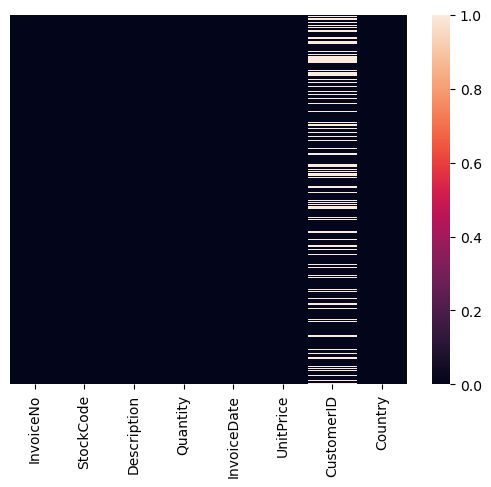

In [7]:
sns.heatmap(df.isnull(), yticklabels=False)

There are many values missing for CustomerID. We cannot do a segmentation analysis on customer data without a unique ID identifying a customer. So we will drop all the entries with null values in CustomerID. This will also eliminate the missing values in Description column.

In [11]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

<AxesSubplot: >

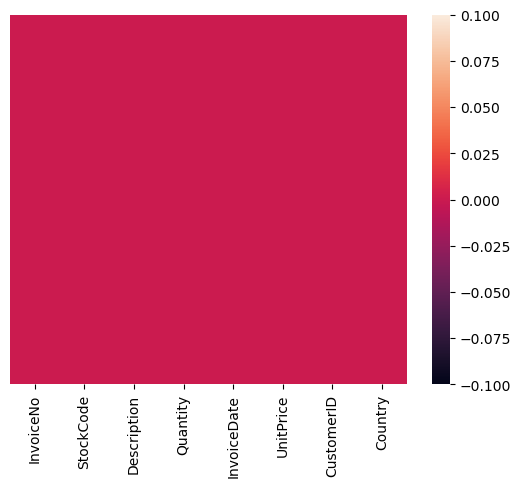

In [9]:
 sns.heatmap(df.isnull(), yticklabels=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


<BR>

### Eliminating Duplicate Values

We will eliminate all the duplicate entries.

In [12]:
df.duplicated().sum()

5225

In [13]:
df.drop_duplicates(inplace = True)

### Get Cancellation Data

In [14]:
pd.DataFrame(df['InvoiceNo'].apply(lambda x:'C' in x)).value_counts()

InvoiceNo
False        392732
True           8872
dtype: int64

In [15]:
df['Cancellation'] = df['InvoiceNo'].apply(lambda x: 0 if 'C' in x else 1)

We observe that about 9000 orders were cancelled

### Country Data Vectorisation 

Since most of the orders are from UK, we will vectorise it such that orders from UK are 1 else orders are 0.

In [16]:
df['UK'] = df['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

We have some values of Quantity which are negative. These are values for orders which were returned as well as discounts and other charges. 

In [16]:
df[df['Quantity']<0].count() 

InvoiceNo       8872
StockCode       8872
Description     8872
Quantity        8872
InvoiceDate     8872
UnitPrice       8872
CustomerID      8872
Country         8872
Cancellation    8872
UK              8872
dtype: int64

<BR>

### Cancelled Orders Cleaning

In [17]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

In [18]:
print("Entry to remove: {}".format(len(entry_to_remove)))
print("Doubtful entries: {}".format(len(doubtfull_entry)))

Entry to remove: 7521
Doubtful entries: 1226


In [19]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("Number of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

Number of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,UK,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0,1,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0,1,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0,1,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0,1,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0,1,0


In [20]:
df = df_cleaned.copy()

In [21]:
df.to_csv('Cleaned Dataset.csv')

In [17]:
df = pd.read_csv("Cleaned Dataset.csv", index_col = 0,dtype =  {'CustomerID': str, 'Quantity' : 'int64', 'InvoiceNo': str})

In [18]:
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'])

### Drop Stock Code 

In [19]:
df.drop(['StockCode'], axis = 1, inplace = True)

<BR>

### Visualize Data

In [25]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,UK,QuantityCanceled
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,1,1,0
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,1,0
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,1,1,0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,1,0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,1,1,0


In [26]:
df.describe()

,Quantity,UnitPrice,Cancellation,UK,QuantityCanceled
count,392857.000000,392857.000000,392857.000000,392857.000000,392857.000000
mean,13.143587,3.139151,0.999682,0.889247,0.624314
std,181.564772,22.466373,0.017835,0.313826,175.527084
min,-720.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.250000,1.000000,1.000000,0.000000
50%,6.000000,1.950000,1.000000,1.000000,0.000000
75%,12.000000,3.750000,1.000000,1.000000,0.000000
max,80995.000000,8142.750000,1.000000,1.000000,80995.000000


<BR>

#### The describe shows that most of our data within 75th percentile is below 10, however the maximum value is extraordinarily greater than 10. This suggests that there are some outliers 

<AxesSubplot: ylabel='Quantity'>

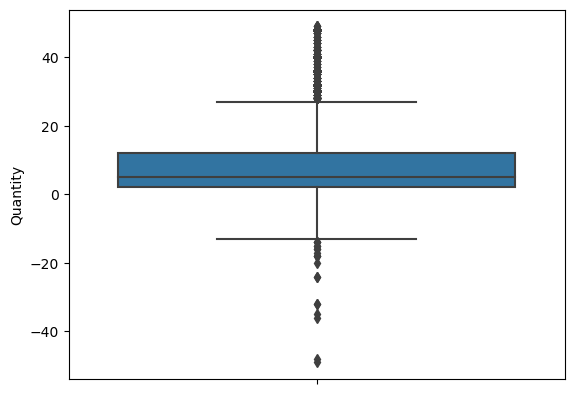

In [28]:
sns.boxplot(y = 'Quantity', data = df[(df['Quantity']<50) & (df['Quantity']>-50)])

<AxesSubplot: ylabel='UnitPrice'>

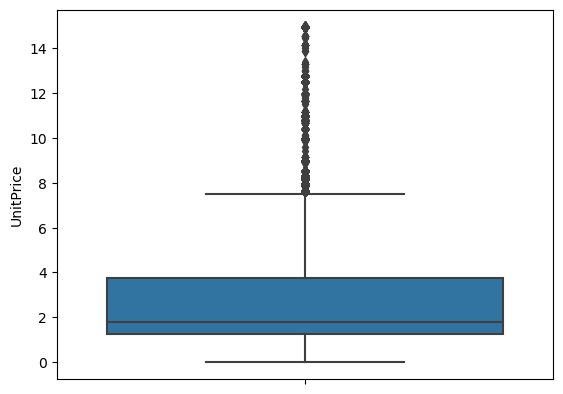

In [29]:
sns.boxplot(y = 'UnitPrice', data = df[(df['UnitPrice']<15) & (df['UnitPrice']>-50)])

<BR>

# Exploratory Data Analysis

<BR>

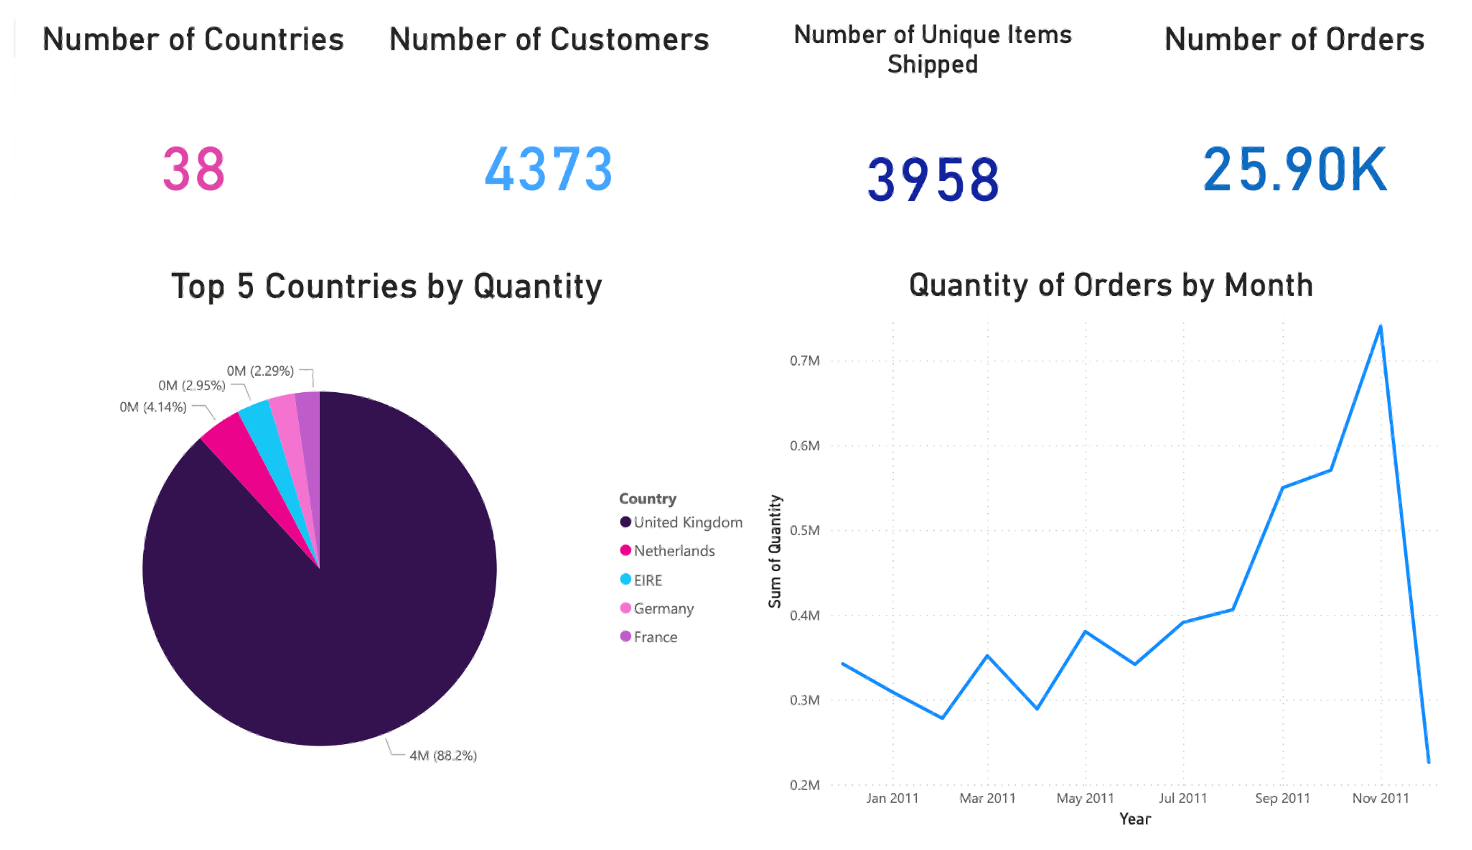

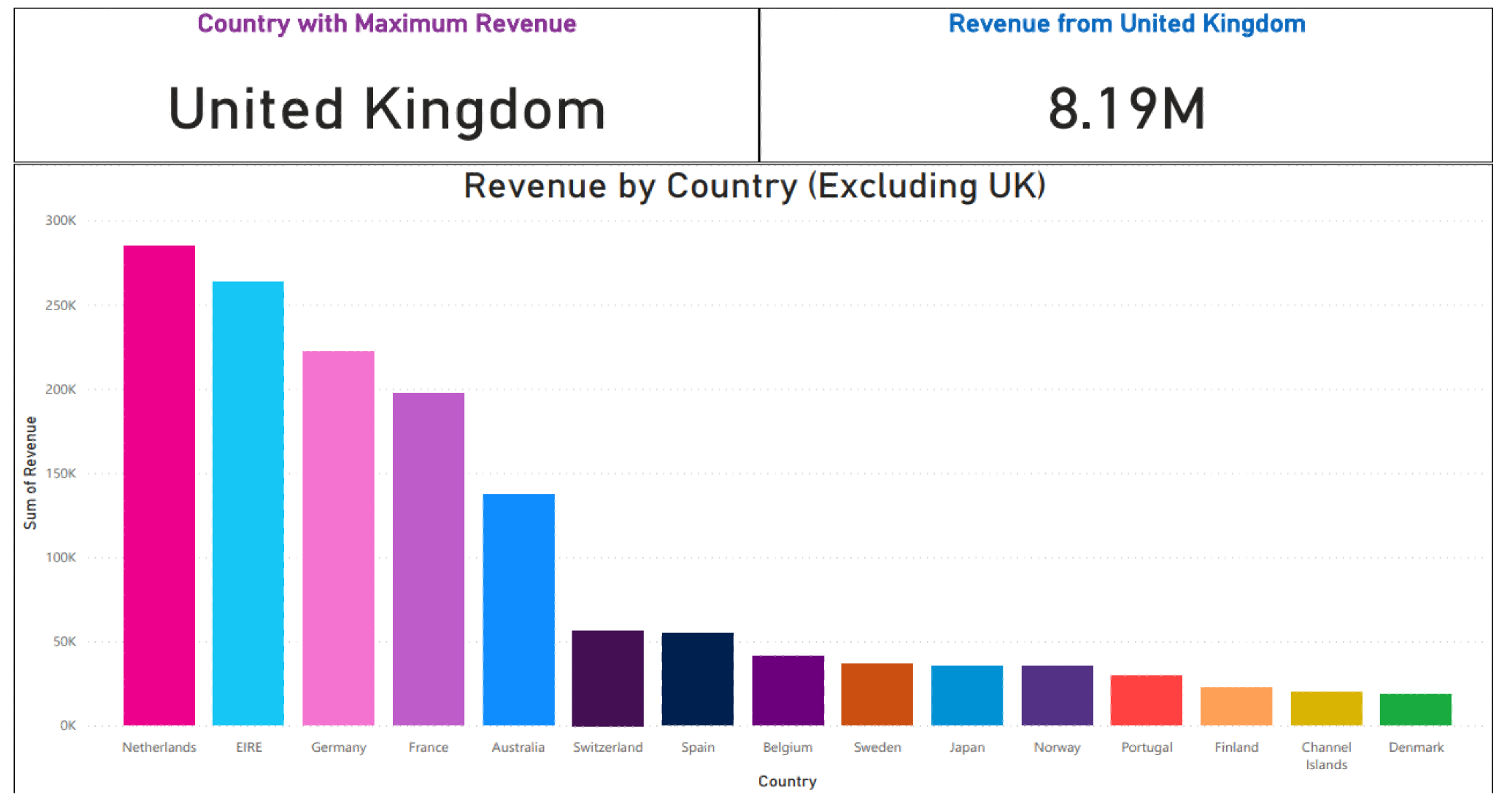

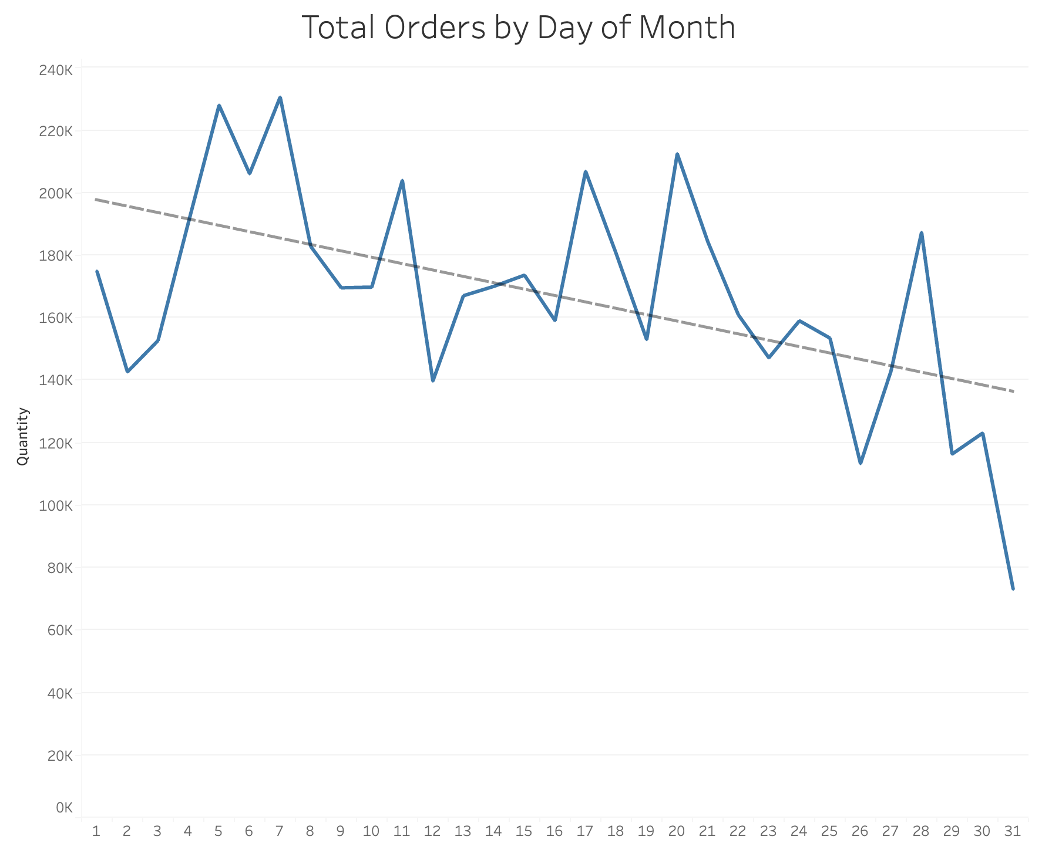

### Univariate Analysis

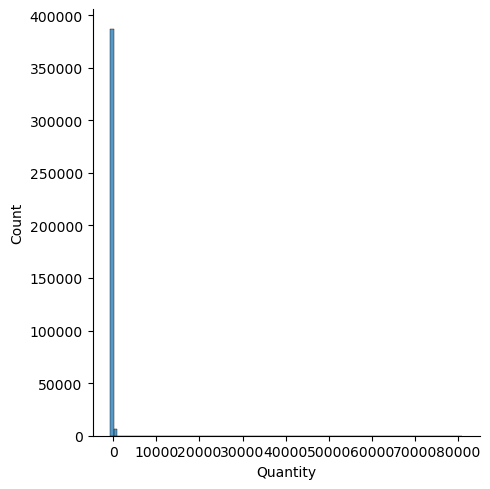

In [27]:
sns.displot(df.Quantity, bins = 100)

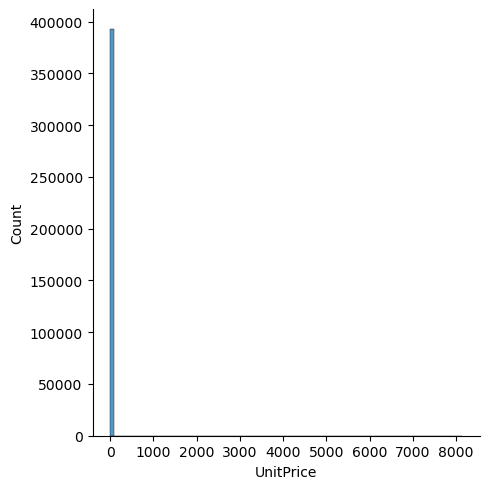

In [30]:
sns.displot(df.UnitPrice, bins = 100)

<BR>

### Bivariate Analysis

In [32]:
df.corr()

,Quantity,UnitPrice,Cancellation,UK,QuantityCanceled
Quantity,1.000000,-0.004574,0.003128,-0.015187,0.966687
UnitPrice,-0.004574,1.000000,-0.033820,-0.019376,-0.000177
Cancellation,0.003128,-0.033820,1.000000,-0.004022,0.000063
UK,-0.015187,-0.019376,-0.004022,1.000000,0.000676
QuantityCanceled,0.966687,-0.000177,0.000063,0.000676,1.000000


#### There are no significant relationships between the variables.

<AxesSubplot: xlabel='Quantity', ylabel='UnitPrice'>

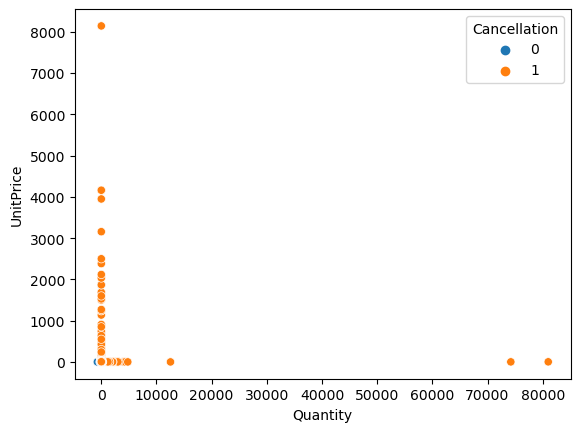

In [33]:
sns.scatterplot(data = df, x = 'Quantity', y = 'UnitPrice', hue = 'Cancellation')

<AxesSubplot: xlabel='Quantity', ylabel='UnitPrice'>

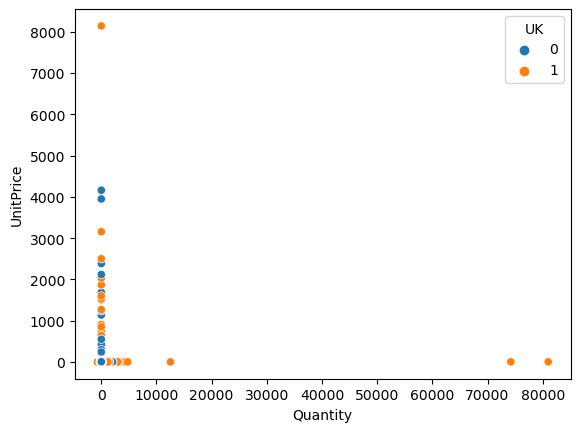

In [34]:
sns.scatterplot(data = df, x = 'Quantity', y = 'UnitPrice', hue = 'UK')

<BR>

### Multivariate Analysis

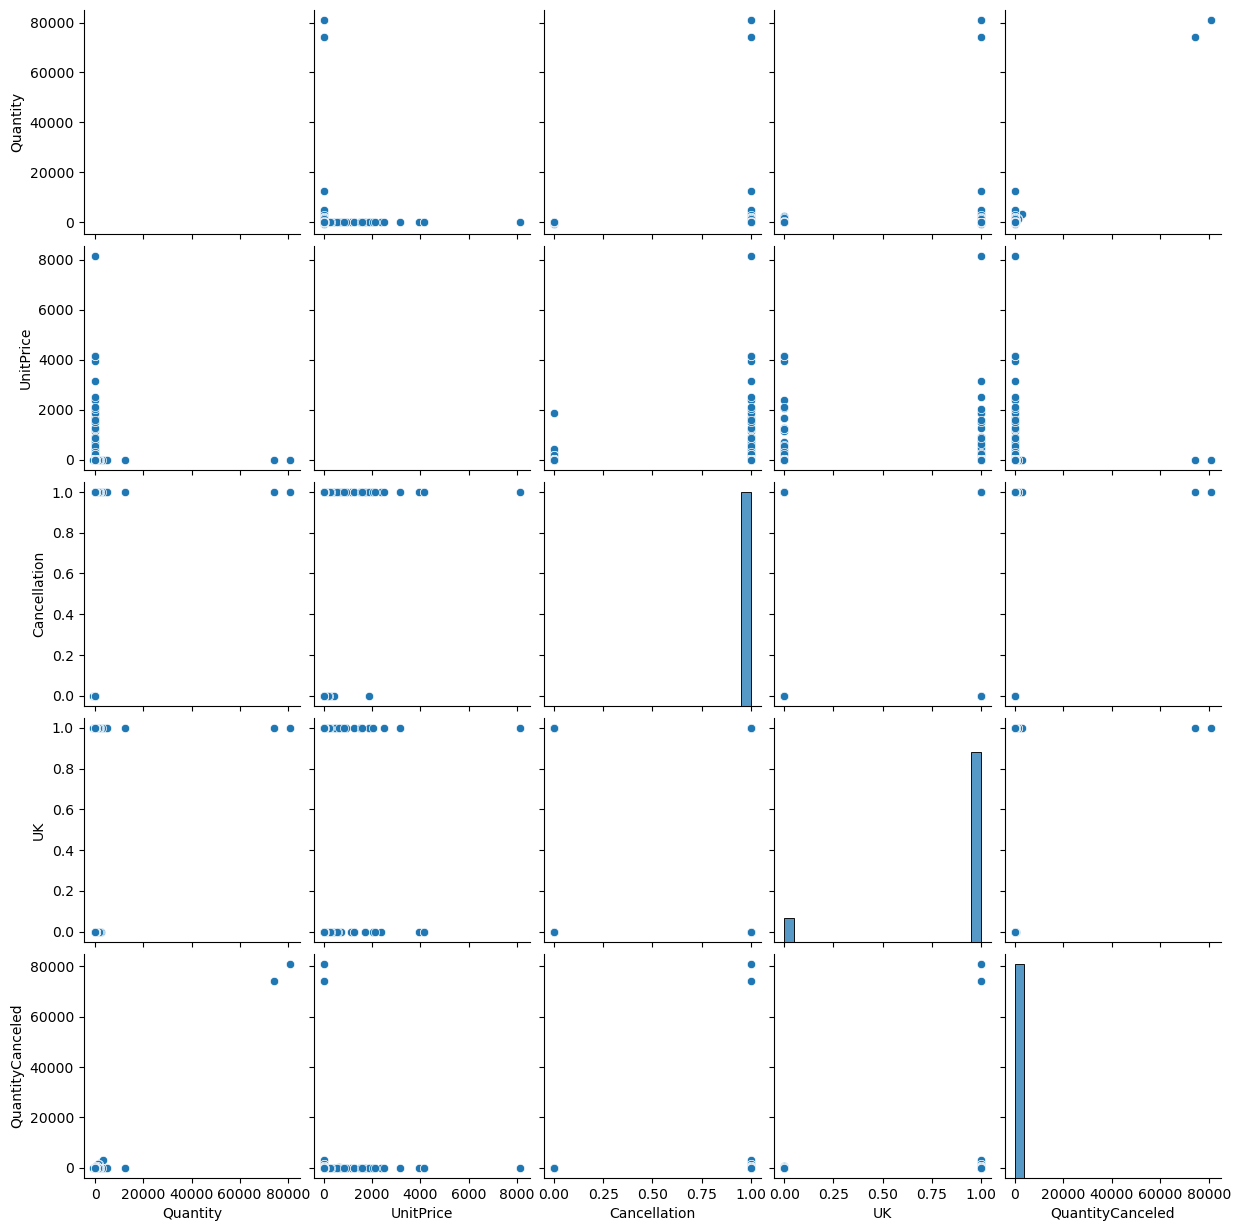

In [35]:
sns.pairplot(df)

<BR>

<BR>

# Feature Engineering

#### We will extract features from Description data using the Universal Sentence Encoder. It takes a sentence of any length and converts it into a vector of shape  [1, 512]


In [36]:
import tensorflow as tf

2023-01-05 14:55:49.465011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
import tensorflow_hub as hub

In [38]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

2023-01-05 14:55:53.903327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


<BR>

## Universal Sentence Encoder

#### Semantic Similarity Visualisation

In [39]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = model(messages_)
    plot_similarity(messages_, message_embeddings_, 90)


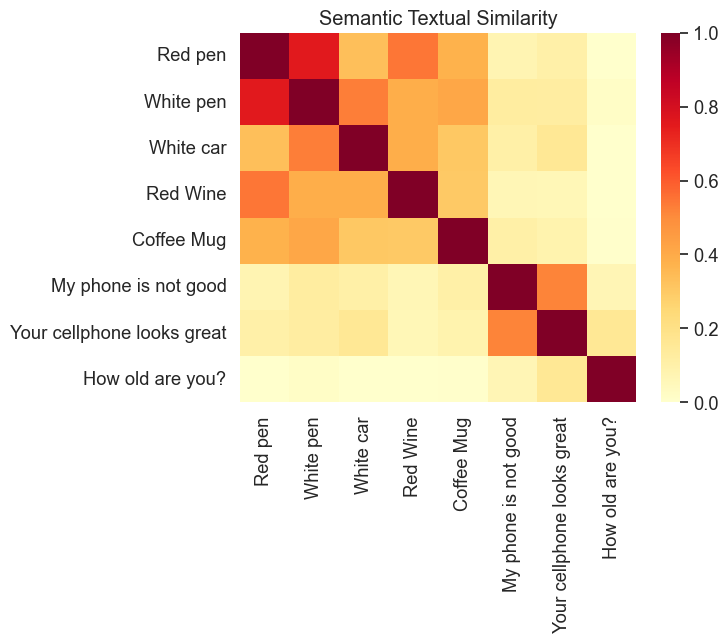

In [40]:
messages = [

    "Red pen",
    "White pen",
    "White car",
    "Red Wine",
    "Coffee Mug",
    "My phone is not good",
    "Your cellphone looks great",
    "How old are you?"
   
]

run_and_plot(messages)


<BR>

We will now use the Universal Sentence Encoder to obtain sentence encodings of the description variable

In [41]:
def gse(x):
    try:
        return model([x]).numpy()
    except:
        return np.zeros([1,512])[0]

We will store these encodings in a new column 'Features'

In [85]:
df['Features'] = df['Description'].apply(gse)

In [86]:
df_features = pd.DataFrame()

In [89]:
for i in range(512):
        #print('Feature_{} Done'.format(i))
        df_features['Feature_{}'.format(i)] = [x[0][i] for x in df['Features']]

In [171]:
df_features

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_502,Feature_503,Feature_504,Feature_505,Feature_506,Feature_507,Feature_508,Feature_509,Feature_510,Feature_511
0,0.017054,0.045437,-0.049847,0.054108,0.051426,-0.047206,0.013008,0.058098,-0.017443,0.023920,...,0.035894,-0.049344,0.025141,-0.001594,0.043812,-0.011459,-0.039166,-0.020211,0.020094,-0.019979
1,0.036419,0.033776,0.074208,0.011864,0.037606,-0.078329,0.041849,0.025840,-0.047774,0.012297,...,0.028112,-0.048670,0.004904,0.074908,0.016309,-0.065239,-0.029761,-0.031854,0.051086,-0.020002
2,-0.009727,-0.002434,0.009474,0.000852,0.007350,-0.075126,0.059542,0.067033,-0.049231,0.002453,...,0.053760,-0.003404,-0.018660,-0.050039,0.078531,-0.000659,-0.058767,-0.073053,-0.012831,0.014067
3,0.059920,0.003425,0.000590,0.041589,0.058168,0.062989,-0.076971,0.055146,0.020894,0.034751,...,0.064746,-0.012101,-0.004883,-0.024400,-0.058896,-0.022777,-0.034895,0.008546,-0.053412,-0.026817
4,0.056702,0.051758,-0.082853,0.013037,-0.016620,-0.005651,-0.047084,0.049864,0.021853,0.057130,...,-0.007711,-0.066532,-0.050669,-0.040184,-0.049838,-0.013684,-0.034393,-0.001844,-0.034911,0.007077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392852,0.011194,-0.030866,0.041472,0.055285,0.076580,0.003214,0.023670,0.018335,-0.076714,-0.004202,...,0.068158,-0.054262,0.008716,0.036054,0.006293,-0.040865,-0.072081,-0.009830,0.026568,0.049664
392853,-0.036779,0.015483,0.073935,-0.042422,-0.075411,0.033000,-0.033312,0.002655,0.001325,-0.043708,...,0.021645,-0.076425,-0.018925,0.072259,0.033615,-0.033623,-0.029111,-0.036854,0.038919,0.020582
392854,-0.044645,0.068459,0.073315,-0.042237,-0.083115,0.014463,0.038710,0.034515,-0.024053,-0.007972,...,0.045645,-0.080277,-0.028471,0.037540,0.003469,-0.025972,-0.040315,0.001162,0.060672,-0.013066
392855,-0.024855,0.041855,0.067579,0.002539,-0.079469,0.001022,0.034773,0.026382,-0.051118,-0.041795,...,0.068731,-0.056780,-0.001058,0.019079,0.063684,-0.006041,-0.071818,-0.002612,0.056193,0.015900


Save the Data Frame 

In [100]:
df_features.to_csv('Feature Matrix.csv')

In [42]:
df_features = pd.read_csv("Feature Matrix.csv", index_col = 0)

<BR>
    

### Dimensionality Reduction using PCA

The Universal Sentence Encoder gives 512 dimensions as output. These many dimensions are not appropriate to conduct any modelling due to exessively high computational cost. We will reduce the dimensions of these outputs using PCA.

In [43]:
import matplotlib.pyplot as plt

In [44]:
from sklearn.decomposition import PCA

In [45]:
n_components=40

In [46]:
pca = PCA(n_components=n_components)

In [47]:
pca.fit(df_features)
fr = pca.transform(df_features)

In [48]:
features_reduced = pd.DataFrame()

In [49]:
for i in range(n_components):
        features_reduced['Feature_{}'.format(i)] = [x[i] for x in fr]
        #print('Feature_{} Done'.format(i))

<BR>

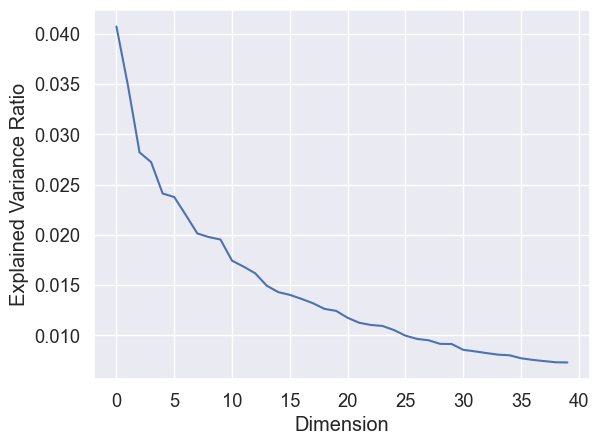

In [50]:
# Get the explained variance ratios of the dimensions
explained_variance_ratios = pca.explained_variance_ratio_

# Plot the explained variance ratios
plt.plot(explained_variance_ratios)
plt.xlabel('Dimension')
plt.ylabel('Explained Variance Ratio')
plt.show()

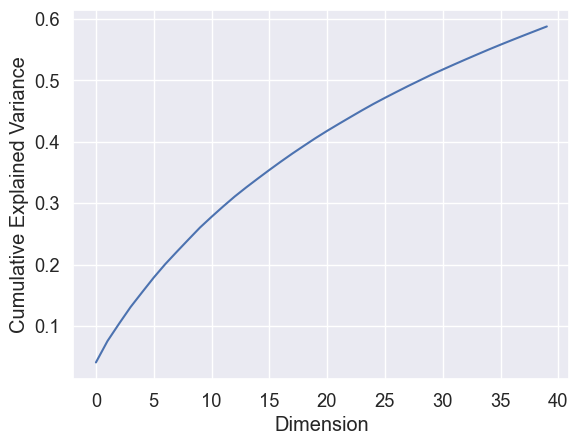

In [51]:
# Get the cumulative sum of the explained variance ratios
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Plot the cumulative explained variance
plt.plot(cumulative_explained_variance)
plt.xlabel('Dimension')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In order to capture at least 60% of the variance of the original dataset, we will take the number of dimensions as 40. We will plot the similarities betweeen consecutive description rows to check the genuineness of the dimensionality reduction.

In [52]:
fr = []
dff = []

In [54]:
for i in range(20):
    a = features_reduced.iloc[[i]].to_numpy()[0]
    b = features_reduced.iloc[[i+1]].to_numpy()[0]

    # Compute the dot product
    dot_product = np.dot(a, b)

    # Compute the norm of the vectors
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (norm_a * norm_b)
    fr.append(cosine_similarity)
    


In [55]:
for i in range(20):
    a = df_features.iloc[[i]].to_numpy()[0]
    b = df_features.iloc[[i+1]].to_numpy()[0]

    # Compute the dot product
    dot_product = np.dot(a, b)

    # Compute the norm of the vectors
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (norm_a * norm_b)
    dff.append(cosine_similarity)
    

In [57]:
from matplotlib.pyplot import figure

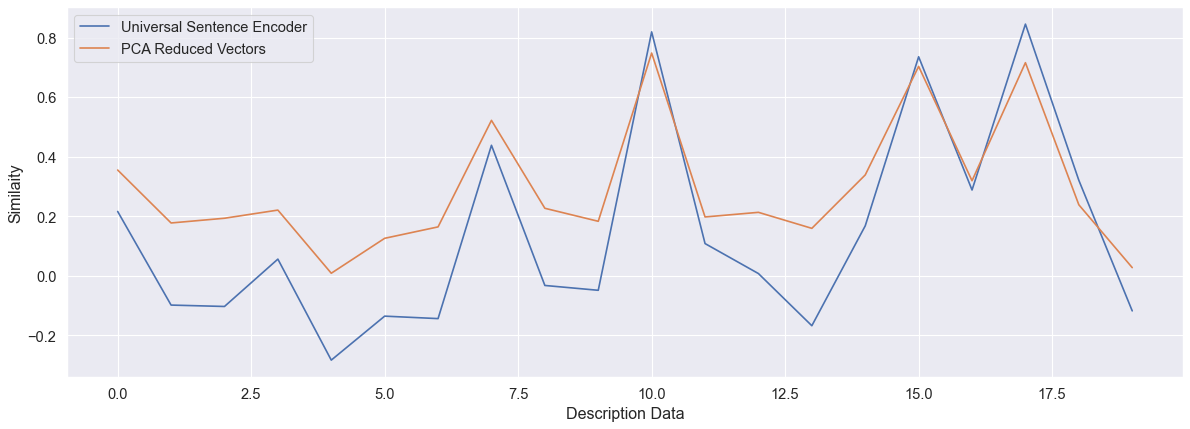

In [58]:
figure(figsize=(18, 6), dpi=80)
plt.plot(fr, label = 'Universal Sentence Encoder')
plt.plot(dff, label = 'PCA Reduced Vectors')

plt.xlabel('Description Data')
plt.ylabel('Similaity')
plt.legend(loc = 'best')
plt.show()

As we can see, the PCA features effectively capture the information from the original Universal Sentence Encoder.

<BR>

<BR>

In [59]:
features_reduced.index = df.index

In [60]:
features_reduced['CustomerID'] = df['CustomerID'].copy()

<BR>

## LSTM

In [525]:
lstm_features = pd.DataFrame(columns = ['CustomerID', 'Features'])

In [526]:
for i in df['CustomerID'].unique():
    a = df[df['CustomerID'] == i]['Description']
    encoded_input = model(a.to_list())
    encoded_input = tf.reshape(encoded_input, [1, a.shape[0], 512])
    
    lstm_model = tf.keras.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(8, input_shape=(None, encoded_input.shape[-1])))
    output = lstm_model(encoded_input)
    
    lstm_features = lstm_features.append({'CustomerID':i, 'Features': np.array(output) }, ignore_index = True)

In [ ]:
for i in range(8):
        lstm_features['Feature_{}'.format(i)] = [x[0][i] for x in lstm_features['Features']]
        print('Feature_{} Done'.format(i))

Feature_0 Done
Feature_1 Done
Feature_2 Done
Feature_3 Done
Feature_4 Done
Feature_5 Done
Feature_6 Done
Feature_7 Done


In [532]:
lstm_features.drop(labels = 'Features', inplace = True, axis = 1)

In [536]:
lstm_features

,CustomerID,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7
0,17850,0.072419,-0.007513,0.085355,-0.031211,0.110590,0.041606,0.008794,-0.024017
1,13047,0.045425,-0.025319,-0.003156,0.000371,0.029561,-0.010609,0.007776,0.012396
2,12583,0.021205,0.023609,0.022979,0.080436,0.002575,0.026431,-0.047755,-0.004518
3,13748,-0.017842,0.003390,0.018015,-0.013038,0.030794,0.017561,0.031334,0.027516
4,15100,-0.044491,0.009747,0.013043,-0.012554,0.018244,-0.034060,0.027336,0.000305
...,...,...,...,...,...,...,...,...,...
4334,13436,-0.048277,-0.001227,0.007910,0.008322,0.012435,0.008867,-0.003914,-0.037389
4335,15520,-0.058167,-0.053367,-0.026295,0.033864,-0.002221,-0.082746,0.005402,0.000228
4336,13298,-0.002983,0.004856,0.032225,-0.015430,0.035286,-0.009524,-0.036057,-0.026568
4337,14569,-0.001545,-0.053845,-0.000221,0.031249,-0.044166,-0.044512,0.034918,0.027612


In [535]:
lstm_features.to_csv('LSTM Features.csv')

In [299]:
lstm_features = pd.read_csv("LSTM Features.csv", index_col = 0, dtype =  {'CustomerID': str})

<BR>

## Preparing the Dataset

In [61]:
df.drop(labels='Description', axis = 1, inplace = True)

df.drop(labels='Country', axis = 1, inplace = True)



We will create a new column of Total Order Value which is obtained by multiplying Quantity purchased by the customer and the Unit Price of each product

In [62]:
df['TOV'] = df['Quantity']*df['UnitPrice']

We need to segment customers into different segments based on the data we have, to do this the data must be reorganised and grouped such that we have data pertinent to each unique customer. 

#### Total Orders

In [63]:
total_orders = df.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
total_orders.rename(columns = {'InvoiceDate':'Total_orders'}, inplace = True)

<BR>

#### Maximum and Minimum Orders

In [64]:
a = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

In [65]:
max_orders = a.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].max()
max_orders.rename(columns = {'InvoiceDate':'Max_orders'}, inplace = True)

In [66]:
min_orders = a.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].min()
min_orders.rename(columns = {'InvoiceDate':'Min_orders'}, inplace = True)

<BR>

#### Mean Order Value 

In [67]:
mean_order_value = df.groupby(by=['CustomerID'], as_index=False)['TOV'].mean()
mean_order_value.rename(columns = {'TOV':'Mean_order_value'}, inplace = True)

#### Country

In [68]:
country_uk = df.groupby(by=['CustomerID'], as_index=False)['UK'].agg(pd.Series.mode)

There are no customers that order from multiple countries

<BR>

#### Recency

In [69]:
from datetime import timedelta

In [70]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

In [71]:
recency = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days})
recency.rename(columns={'InvoiceDate': 'Recency'}, inplace=True)

<BR>

#### Description Features

In [72]:
desc_feat = features_reduced.groupby(by=['CustomerID'], as_index=False)[features_reduced.columns].mean()

<BR>

#### Final Dataset

In [73]:
from functools import reduce

In [74]:
data_frames = [total_orders,max_orders, min_orders, mean_order_value, country_uk, recency, desc_feat]

In [75]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['CustomerID'],
                                            how='outer'), data_frames)

In [76]:
df_merged = df_merged.set_index('CustomerID')

We have reorganised the dataset to reflect individual customer data and buying patterns.

<BR>

In [77]:
df_merged

,Total_orders,Max_orders,Min_orders,Mean_order_value,UK,Recency,Feature_0,Feature_1,Feature_2,Feature_3,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,1,1,77183.600000,1,326,-0.041743,0.068176,0.239114,-0.242331,...,-0.149809,0.132181,-0.193562,0.045360,-0.011502,0.006813,0.119636,-0.013488,0.072629,0.062449
12347,182,47,11,23.681319,0,2,0.020917,-0.025348,0.059338,0.021125,...,0.006961,-0.021620,-0.002704,0.007236,-0.004205,-0.002967,0.012186,0.028180,-0.006352,-0.004481
12348,31,17,3,57.975484,0,75,0.058494,0.169228,0.019588,0.069856,...,0.089281,-0.005838,0.020908,0.007728,-0.021663,-0.007899,0.029630,0.026323,-0.052708,-0.002964
12349,73,73,73,24.076027,0,19,-0.007851,0.037575,0.064507,-0.015262,...,-0.006355,-0.021256,-0.022050,0.000177,-0.001504,0.012576,-0.010342,0.005218,0.002046,-0.006447
12350,17,17,17,19.670588,0,310,-0.051349,-0.034385,-0.048328,-0.055663,...,0.016983,-0.046796,0.002110,0.013063,-0.006740,-0.027860,0.017437,-0.024733,-0.014363,0.008415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,10,10,10,18.060000,1,278,-0.023824,-0.002412,-0.038962,-0.010223,...,0.035025,-0.093286,0.023282,-0.027536,-0.008480,-0.014705,0.005802,0.011690,-0.036512,-0.062436
18281,7,7,7,11.545714,1,181,0.055394,0.035903,-0.135094,0.014583,...,0.014568,-0.002834,-0.044455,-0.003835,0.004918,0.002715,-0.020402,-0.059519,-0.012058,0.030725
18282,12,7,5,14.837500,1,8,-0.007359,0.024471,0.180654,0.019088,...,0.004076,0.002104,0.010190,0.005568,0.031721,-0.010214,-0.023387,0.023301,-0.025061,-0.017558


<BR>


## Clustering Customers

#### K-Means Clustering

There are several clustering algorithms for segmentation. We will first try the K-Means Clustering Algorithm. The two most popular ways of assessing the segents are the ELbow method and the Silhoutte Score. We will also calculate the Davies Bouldin Score.

In [78]:
from sklearn.cluster import KMeans

In [79]:
from matplotlib.pyplot import figure

In [80]:
wcss = []
for i in range(3, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_merged)
    wcss.append(kmeans.inertia_)

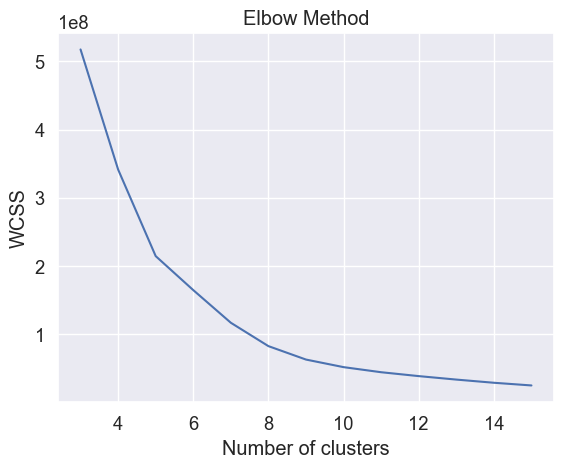

In [81]:
plt.plot(range(3, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We will observe the Silhoutte Scores Graphically

In [82]:
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [83]:
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.9965532604624173
For n_clusters = 3 The average silhouette_score is : 0.9956198348969111
For n_clusters = 4 The average silhouette_score is : 0.9832128496175985
For n_clusters = 5 The average silhouette_score is : 0.962671872321959
For n_clusters = 6 The average silhouette_score is : 0.6007955701964812
For n_clusters = 7 The average silhouette_score is : 0.6105877524378958
For n_clusters = 8 The average silhouette_score is : 0.5007632324875917
For n_clusters = 9 The average silhouette_score is : 0.5084409636828909
For n_clusters = 10 The average silhouette_score is : 0.5226719902527671
For n_clusters = 11 The average silhouette_score is : 0.482043095483041
For n_clusters = 12 The average silhouette_score is : 0.461913785189299
For n_clusters = 13 The average silhouette_score is : 0.471687129106658
For n_clusters = 14 The average silhouette_score is : 0.4253793412372274
For n_clusters = 15 The average silhouette_score is : 0.3992975

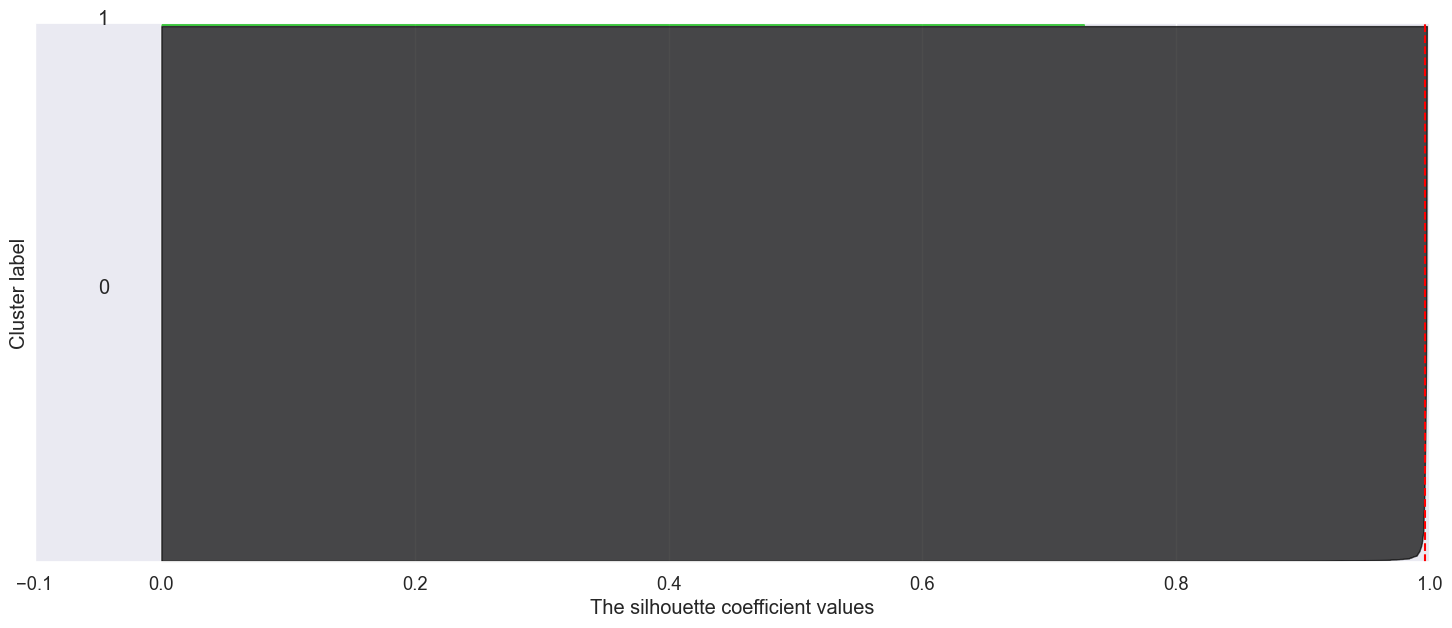

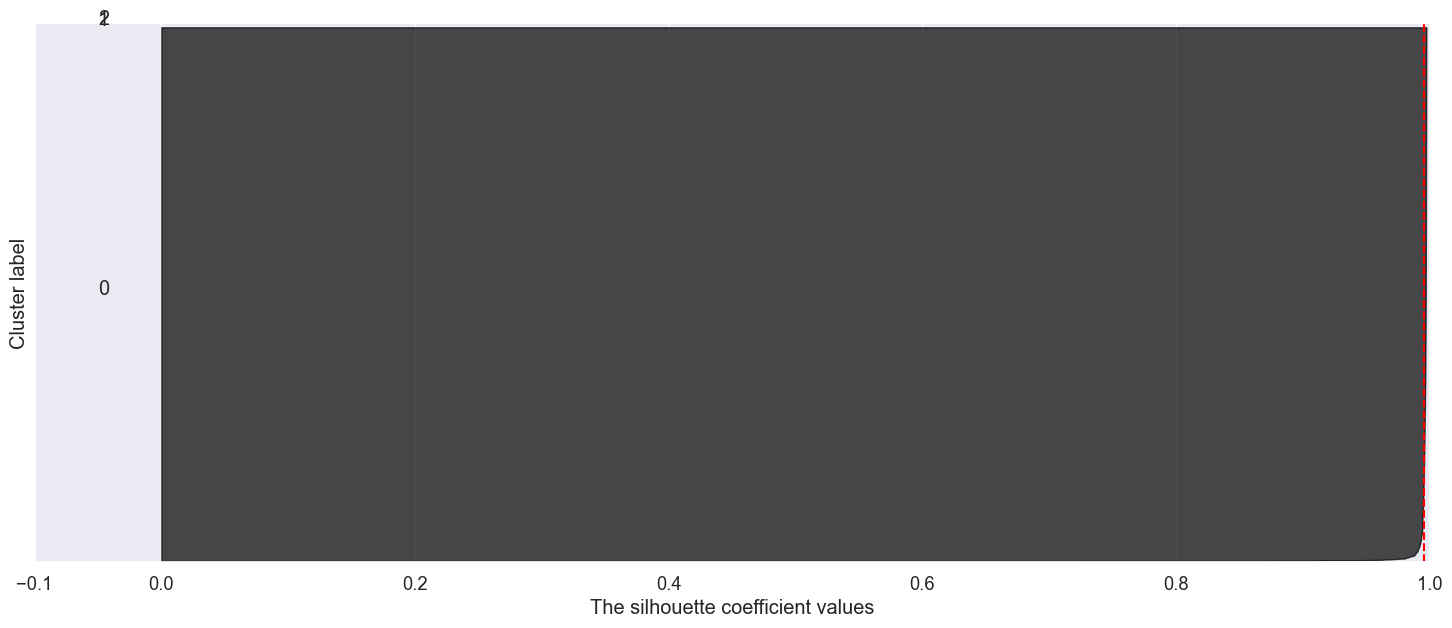

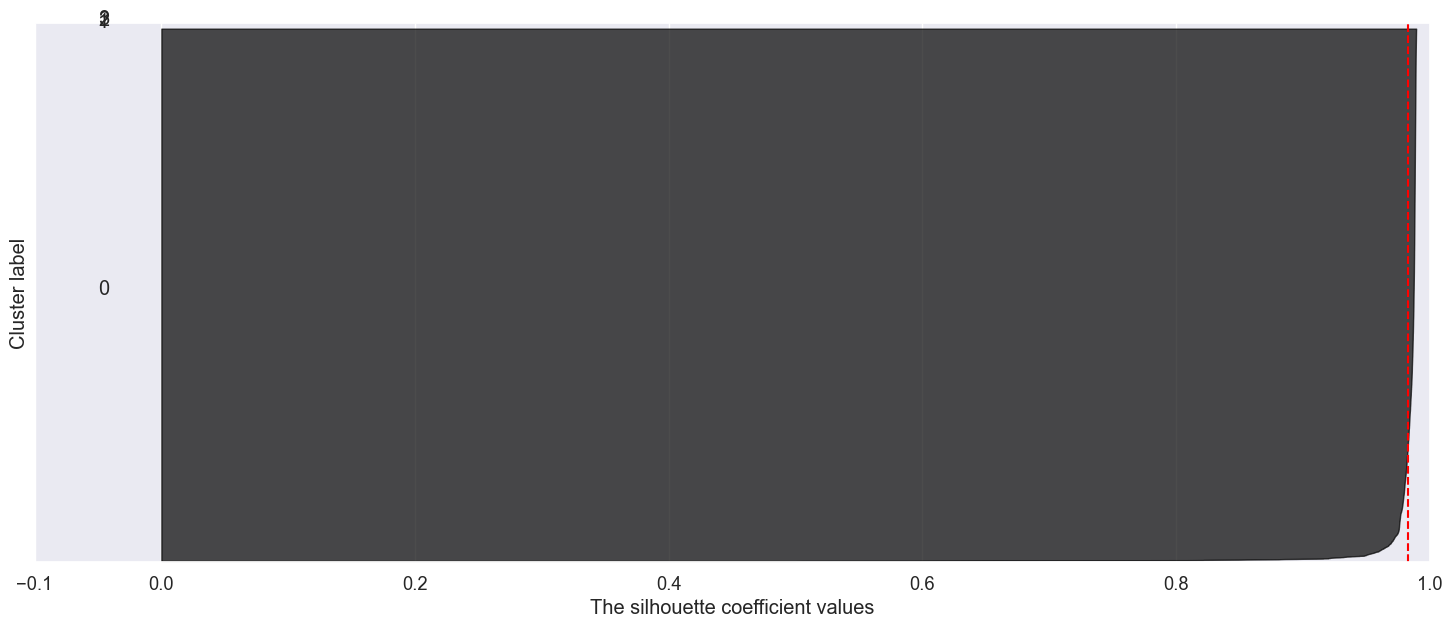

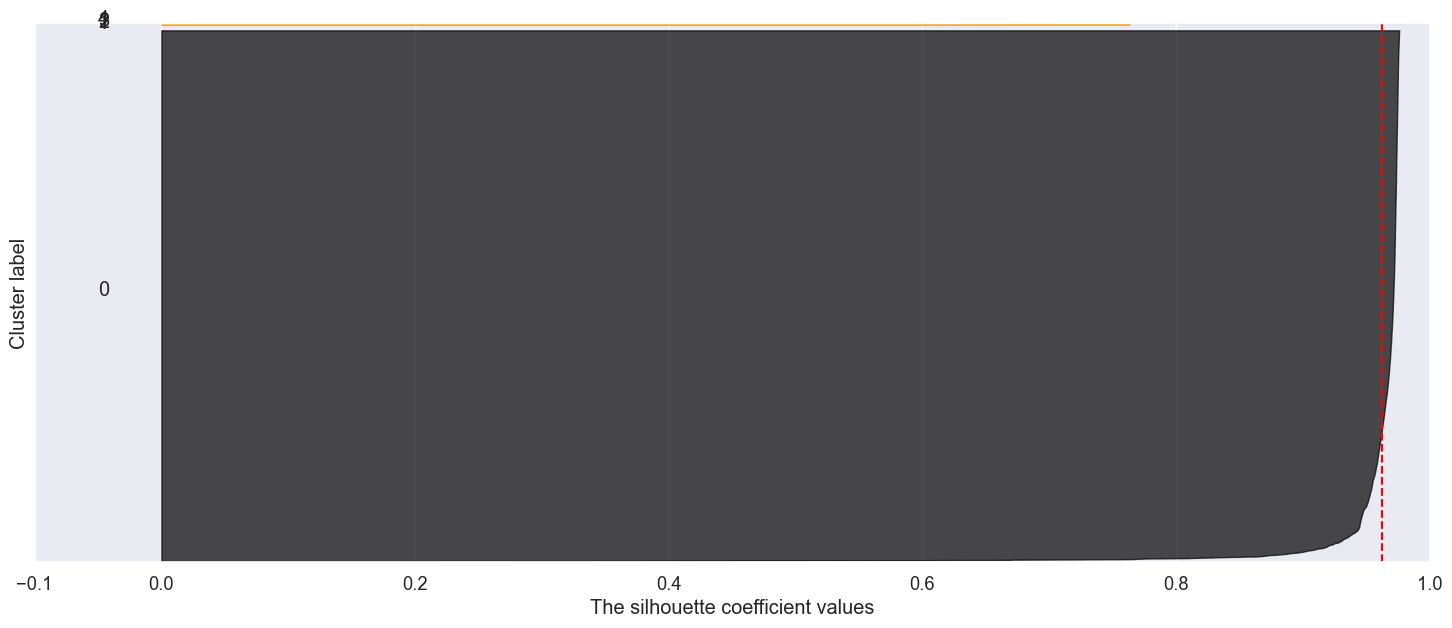

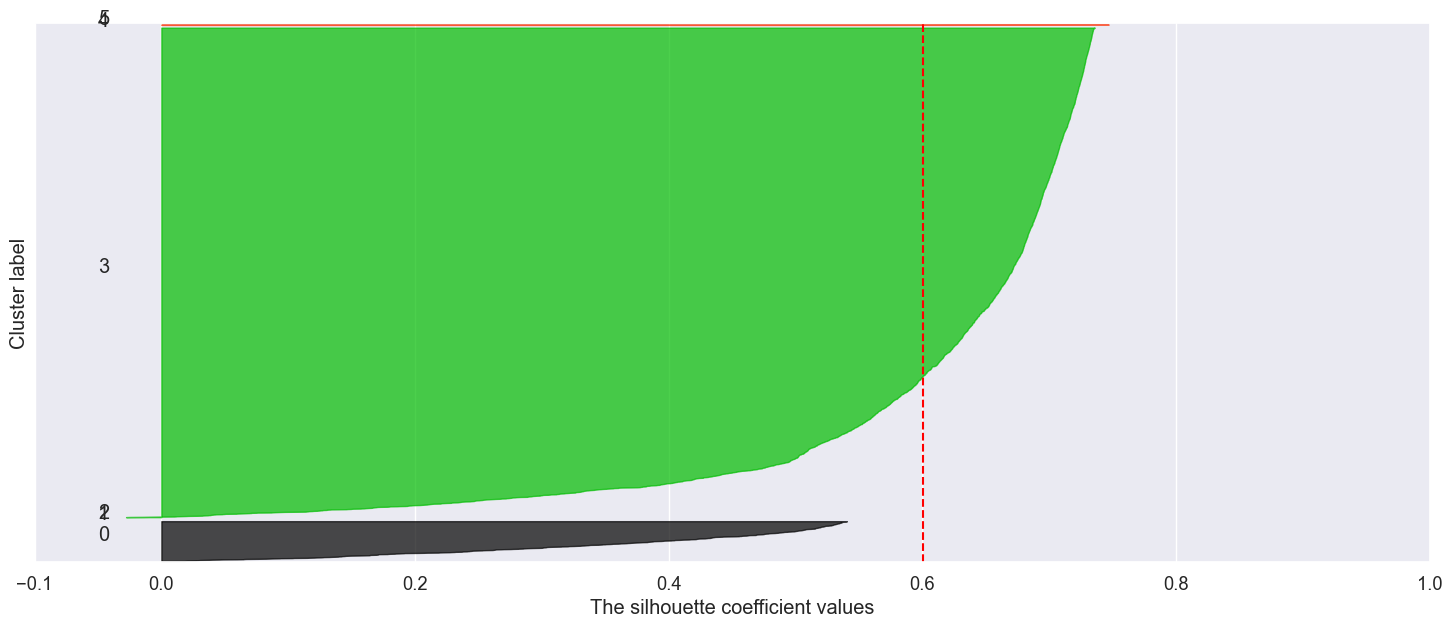

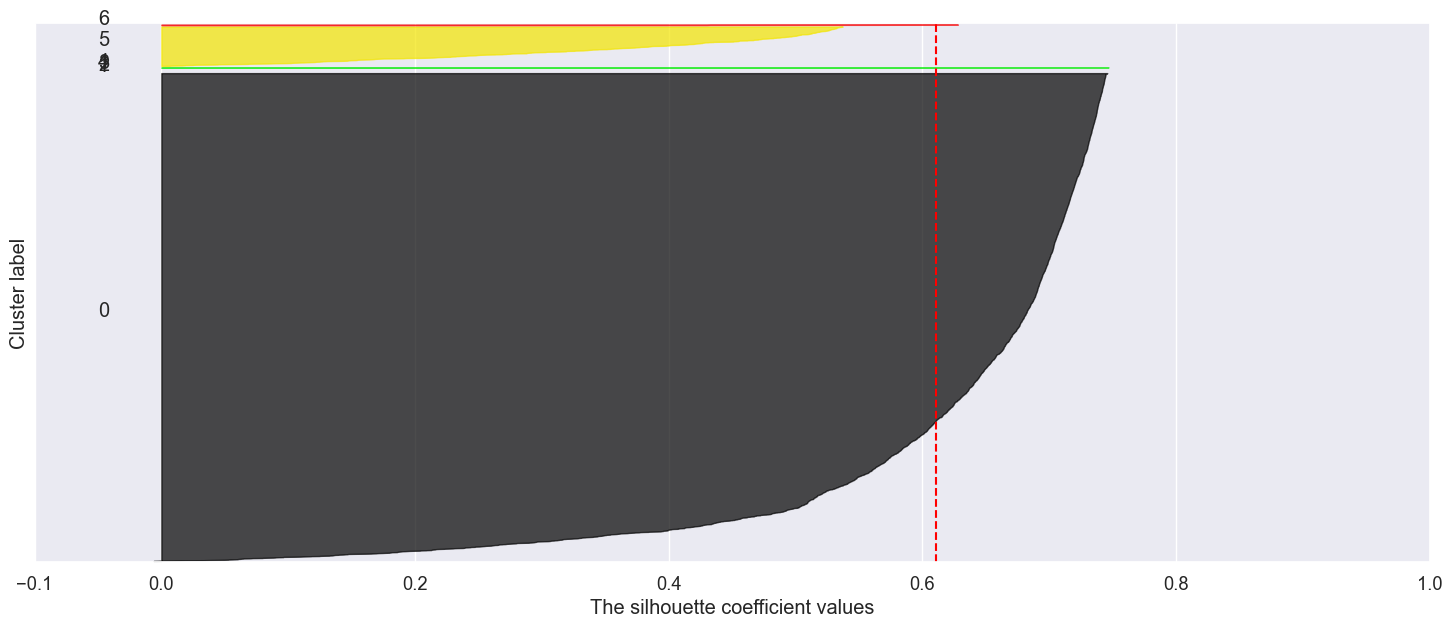

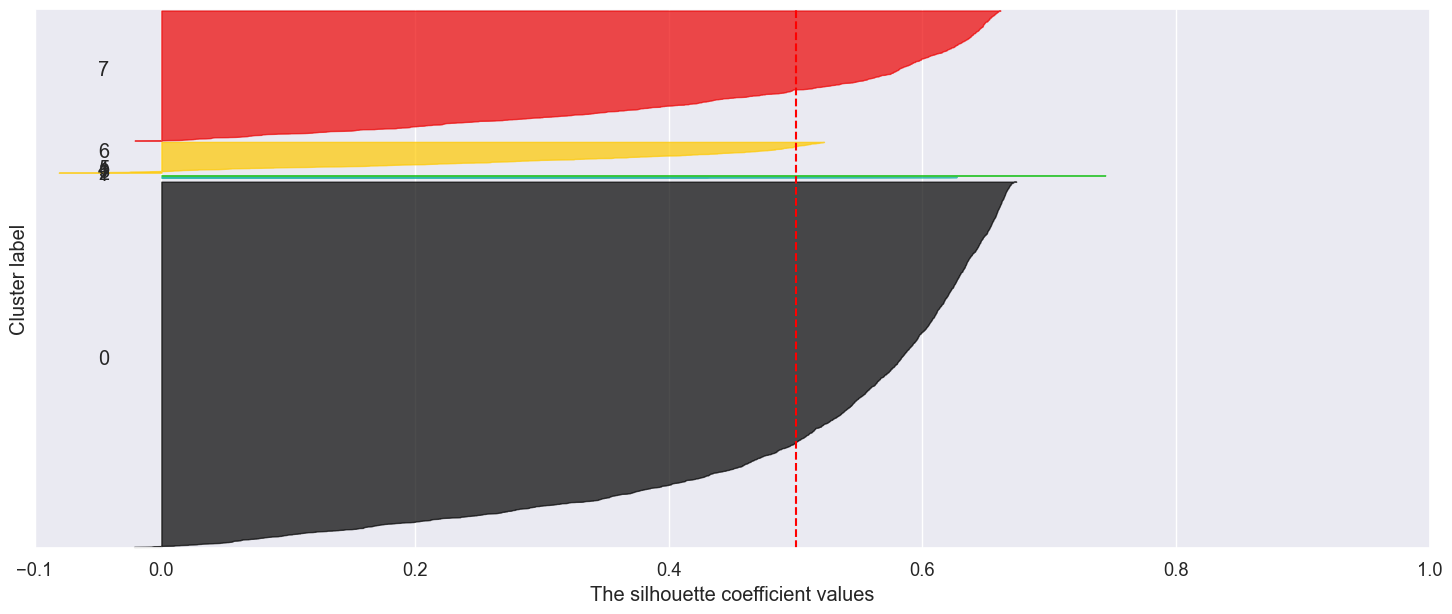

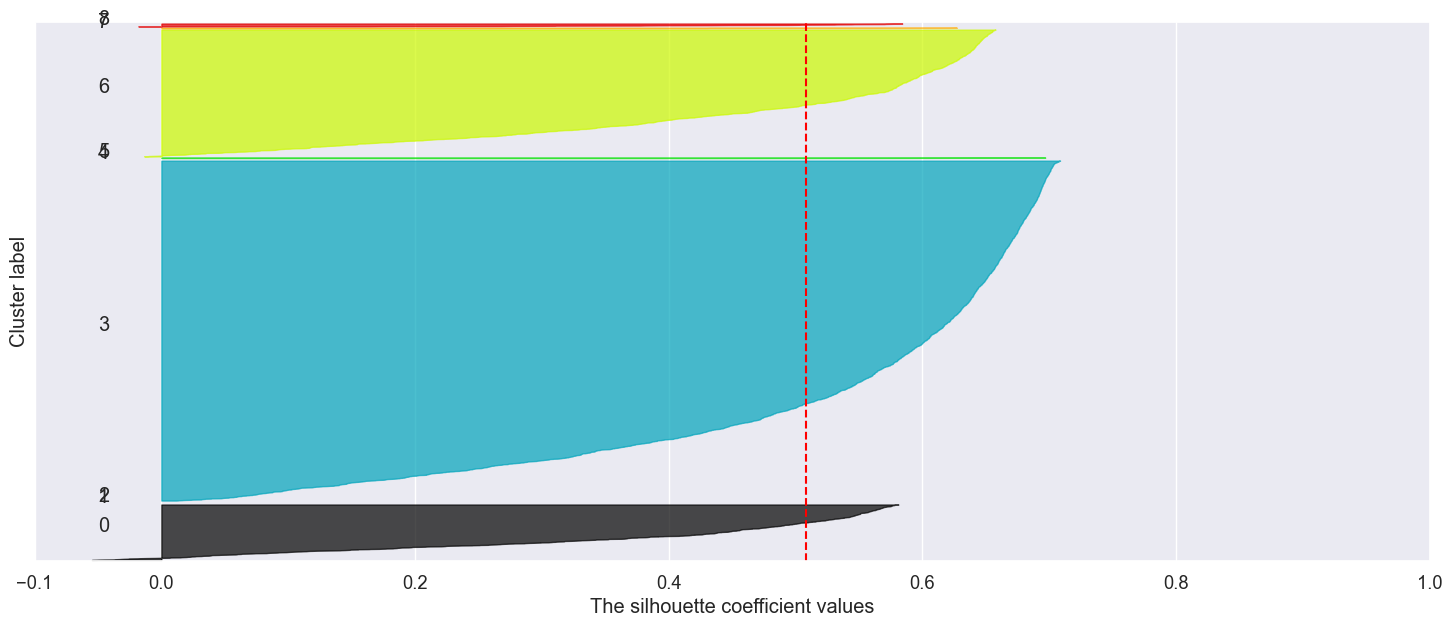

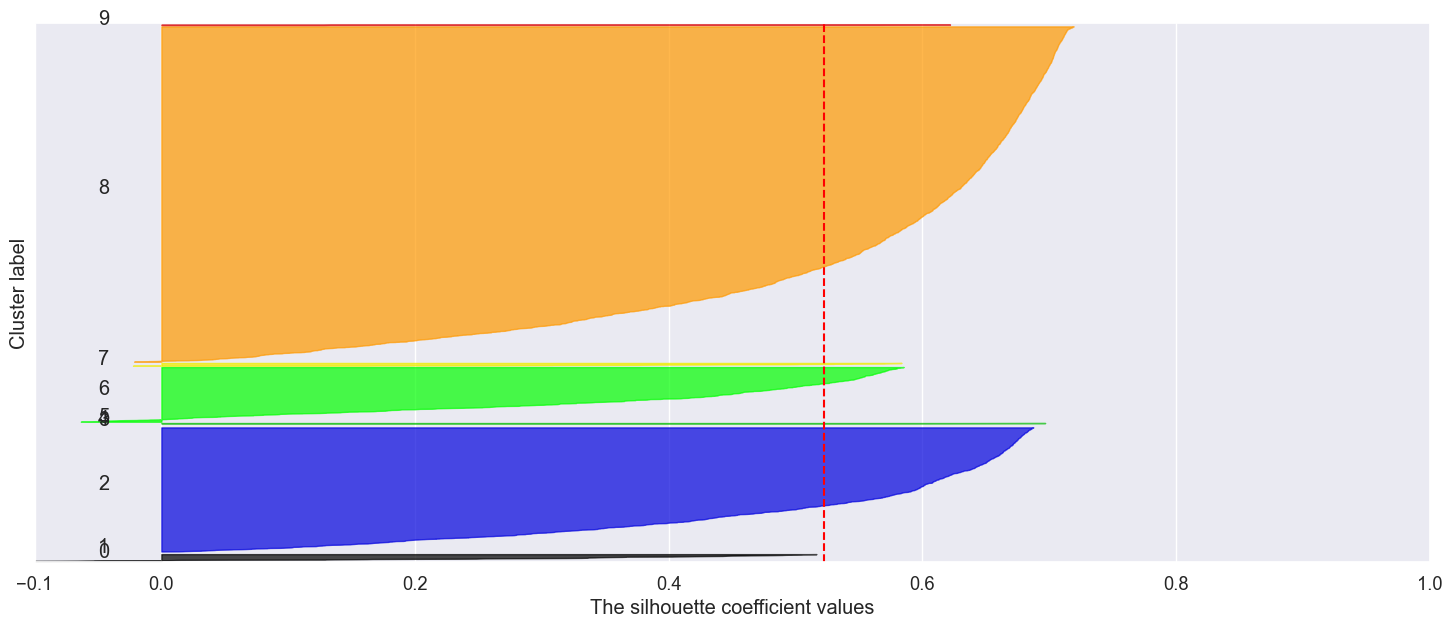

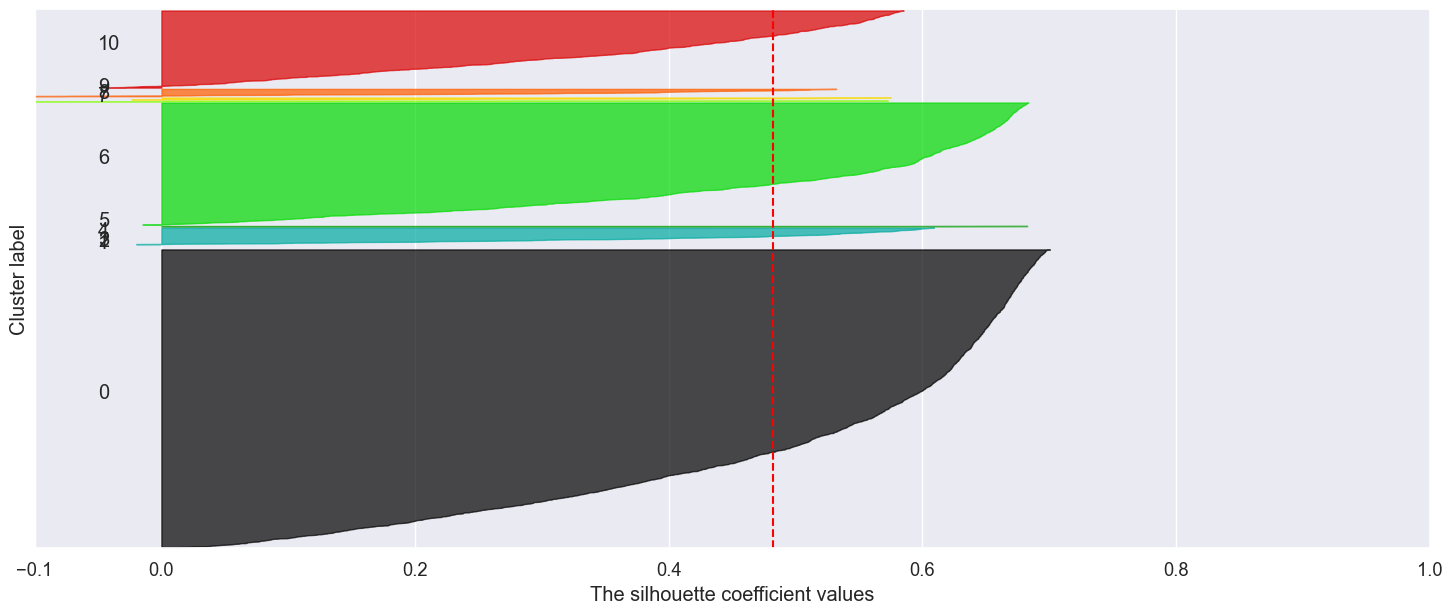

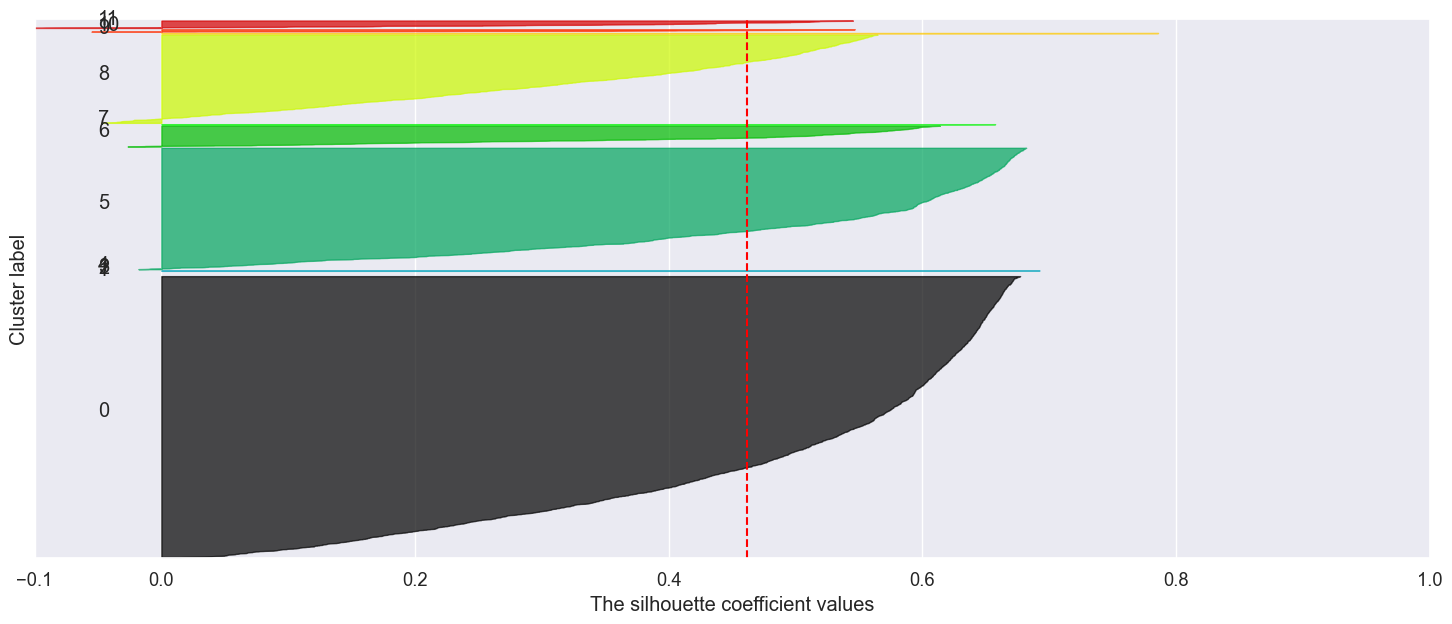

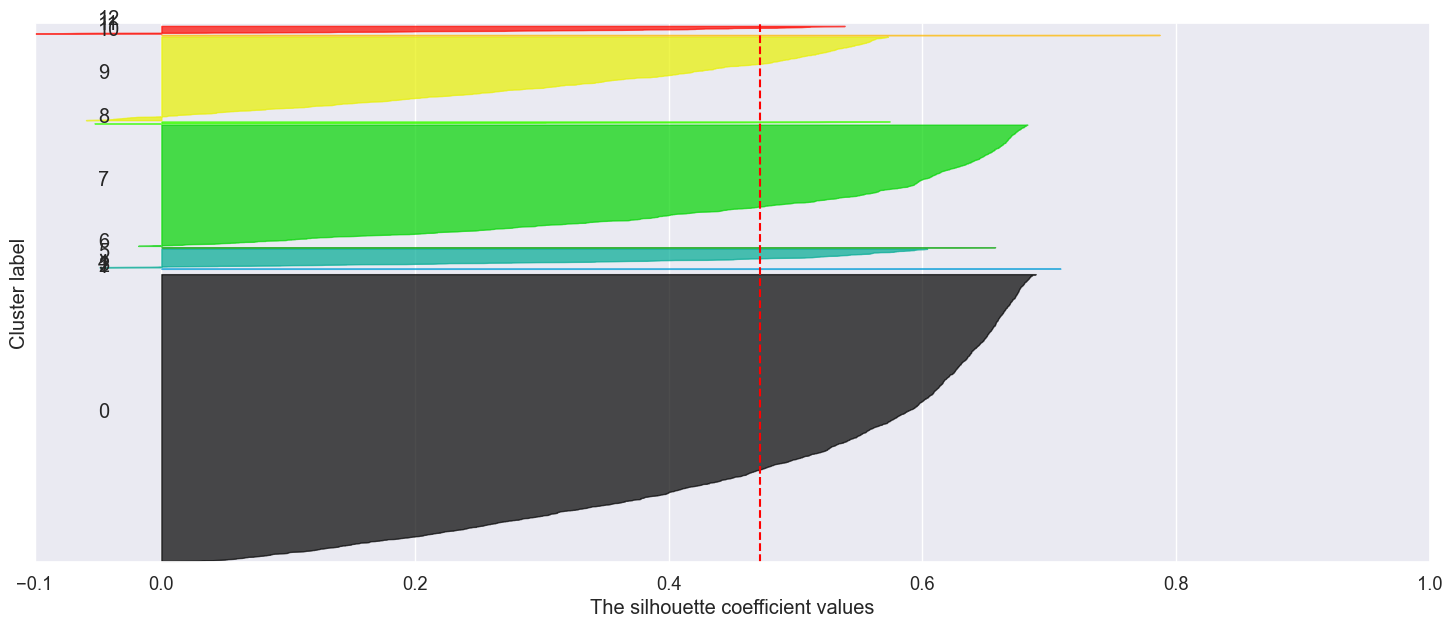

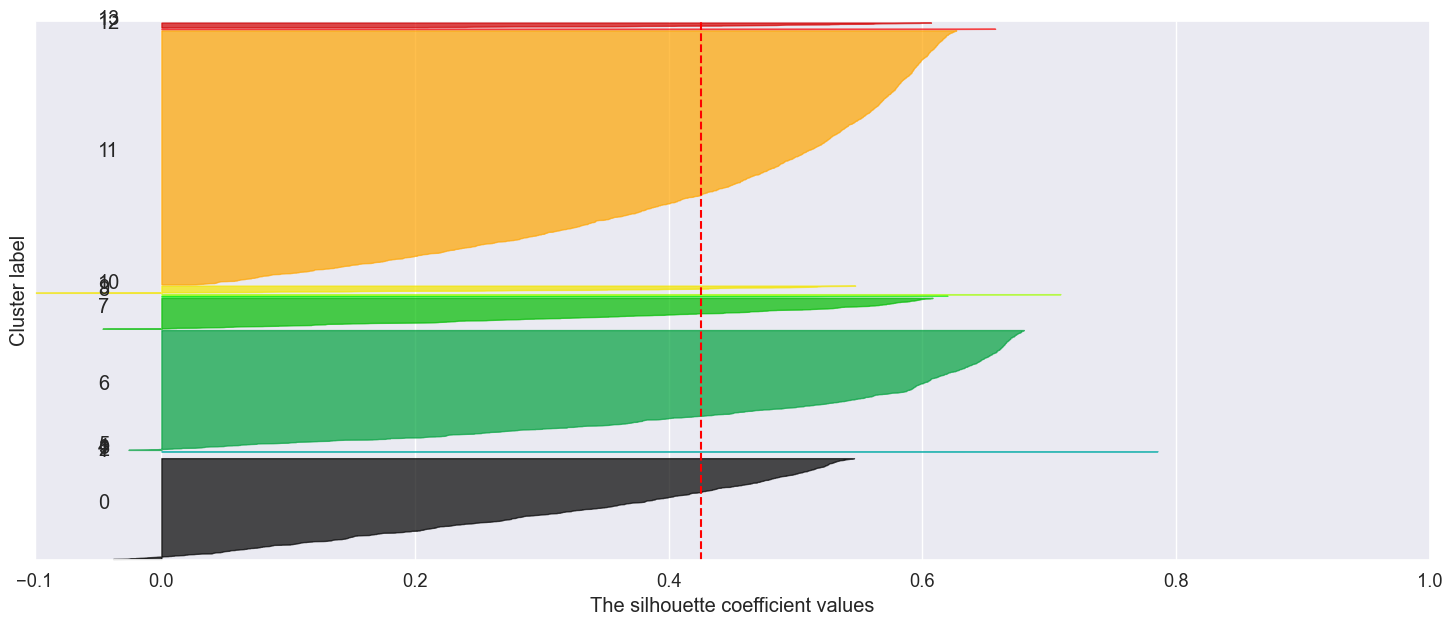

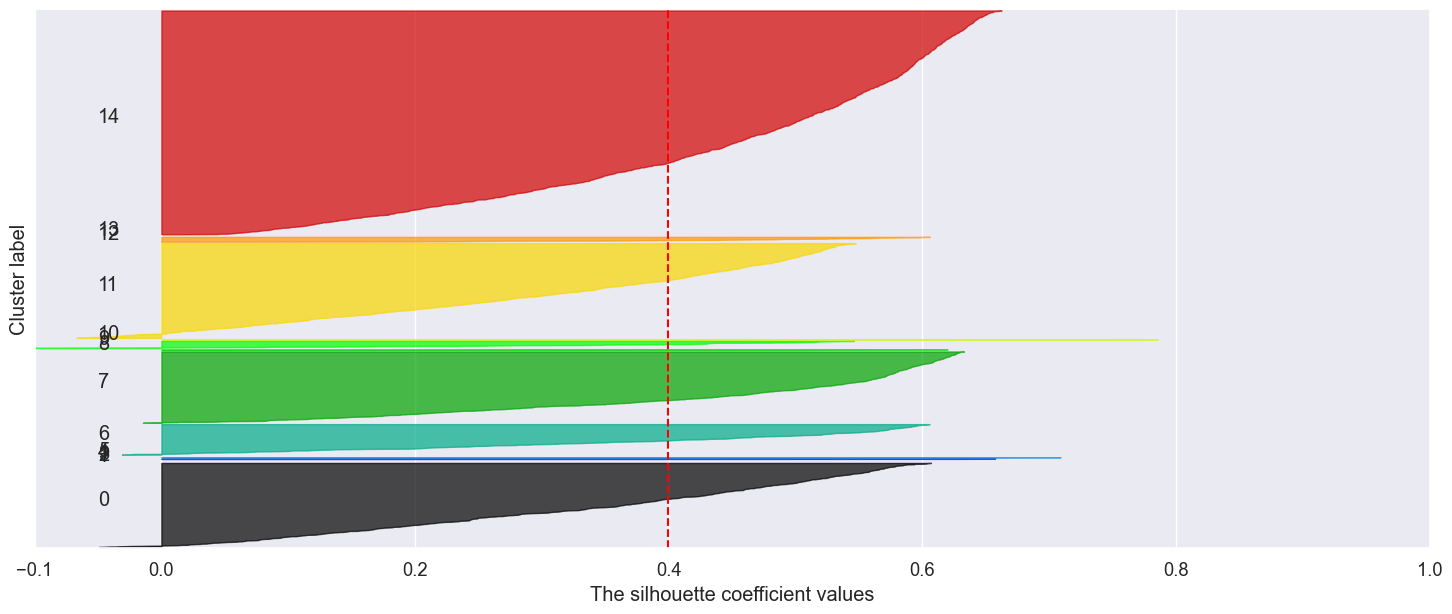

In [84]:
for n_clusters in range(2,16):
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_merged) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=30, random_state=10)
    cluster_labels = clusterer.fit_predict(df_merged)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_merged, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    
    sample_silhouette_values = silhouette_samples(df_merged, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

We will also check the Silhouette and Davies Boudin Score

In [85]:
kmeans_scores = pd.DataFrame(columns = ['Clusters', 'Silhouette score', 'Davies Bouldin Score'])

In [86]:
sc = []
db = []
n_cls = []
for i in range(3,14):  
    n_cls.append(i)
    kmeans_labels=KMeans(n_clusters=i,random_state=123).fit_predict(df_merged)     
    sc.append(silhouette_score(df_merged,kmeans_labels, metric='euclidean').round(3))
    db.append(davies_bouldin_score(df_merged,kmeans_labels).round(3))

In [87]:
kmeans_scores['Clusters'] = n_cls
kmeans_scores['Silhouette score'] = sc
kmeans_scores['Davies Bouldin Score'] = db

In [88]:
kmeans_scores

,Clusters,Silhouette score,Davies Bouldin Score
0,3,0.996,0.002
1,4,0.983,0.007
2,5,0.958,0.143
3,6,0.600,0.311
4,7,0.611,0.334
5,8,0.500,0.378
6,9,0.509,0.393
7,10,0.521,0.399
8,11,0.480,0.441
9,12,0.483,0.434


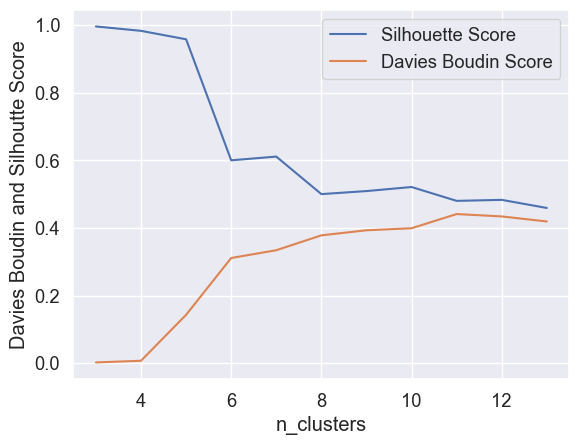

In [89]:

plt.plot(np.arange(3,14),sc, label = 'Silhouette Score')
plt.plot(np.arange(3,14),db, label = 'Davies Boudin Score')
plt.ylabel('Davies Boudin and Silhoutte Score')
plt.xlabel('n_clusters')
plt.legend(loc="best")


<BR>

#### Hierarchical Clustering

We will try another clustering algorithm which is Hierarchical Clustering

In [90]:
from sklearn.cluster import AgglomerativeClustering

In [91]:
hcls_scores = pd.DataFrame(columns = ['Clusters', 'Silhouette score', 'Davies Bouldin Score'])

In [92]:
sc = []
db = []
n_cls = []
for i in range(3,14):   
    hcluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    hcp=hcluster.fit_predict(df_merged)
    n_cls.append(i)
    sc.append((silhouette_score(df_merged,hcp,metric='euclidean')).round(3))
    db.append((davies_bouldin_score(df_merged,hcp)).round(3))

In [93]:
hcls_scores['Clusters'] = n_cls
hcls_scores['Silhouette score'] = sc
hcls_scores['Davies Bouldin Score'] = db

In [94]:
hcls_scores

,Clusters,Silhouette score,Davies Bouldin Score
0,3,0.996,0.002
1,4,0.983,0.007
2,5,0.963,0.103
3,6,0.924,0.218
4,7,0.418,0.362
5,8,0.443,0.373
6,9,0.404,0.458
7,10,0.397,0.492
8,11,0.422,0.492
9,12,0.422,0.467


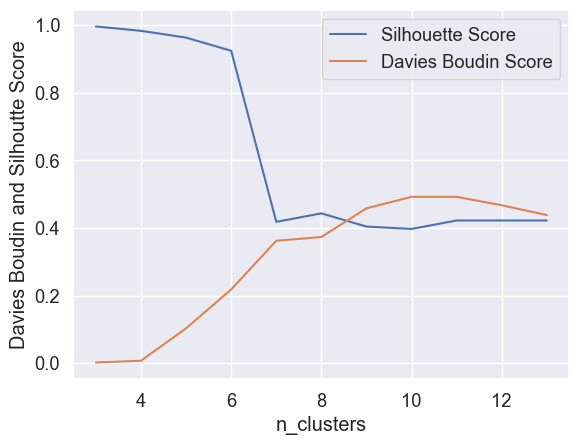

In [95]:

plt.plot(np.arange(3,14),sc, label = 'Silhouette Score')
plt.plot(np.arange(3,14),db, label = 'Davies Boudin Score')
plt.ylabel('Davies Boudin and Silhoutte Score')
plt.xlabel('n_clusters')
plt.legend(loc="best")

<BR>

## Clustering

Analysing the Cluster Sum of Squares (Elbow Method) and Silhouette Plots we take the number of cluster to be 8.

In [350]:
n_clusters = 8
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(df_merged)
clusters_clients = kmeans.predict(df_merged)
silhouette_avg = silhouette_score(df_merged, clusters_clients)
print('Silhouette Score: {:<.3f}'.format(silhouette_avg))

Silhouette Score: 0.500


## Cluster Analysis

We will analyse the distribution of various parameters in the clusters

In [351]:
clusters = pd.DataFrame(clusters_clients, columns = ['Clusters'], index = df_merged.index)

In [352]:
temp = pd.merge(clusters, df_merged, on = clusters.index)

In [353]:
temp.drop('key_0', axis = 1, inplace = True)

In [354]:
temp.index = df_merged.index

<BR>
    

In [355]:
a = pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['Number of clients'])

In [356]:
b = temp.groupby(by=['Clusters'], as_index=True)[df_merged.columns].mean()

In [357]:
pd.merge(a, b, left_on = a.index, right_on = 'Clusters').sort_values(by = 'Clusters')

,Clusters,Number of clients,Total_orders,Max_orders,Min_orders,Mean_order_value,UK,Recency,Feature_0,Feature_1,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
0,0,2997,71.578579,30.818819,14.193193,29.251932,0.902236,43.510177,-0.012561,-0.001364,...,-0.000957,-0.001444,0.000534,0.000429,-0.000588,-0.000728,0.000377,-0.000146,0.001256,-0.001075
7,1,1,3.000000,2.000000,1.000000,56157.500000,1.000000,1.000000,0.006314,0.148055,...,0.014080,-0.027841,0.028155,-0.017870,-0.051151,-0.038625,0.000887,0.025285,0.013360,0.003606
5,2,1,1.000000,1.000000,1.000000,77183.600000,1.000000,326.000000,-0.041743,0.068176,...,-0.153833,0.126938,-0.190318,-0.074544,-0.000190,0.015365,0.100752,-0.021884,0.069143,0.064789
6,3,1,3.000000,1.000000,1.000000,13305.500000,1.000000,182.000000,0.224666,0.164724,...,0.065100,0.118663,-0.025045,0.159961,-0.059981,0.030854,-0.006096,0.072448,0.040970,0.095401
4,4,4,5718.500000,246.500000,2.250000,12.683070,0.750000,2.000000,-0.009548,0.000326,...,0.001987,0.000109,0.000171,-0.002433,0.004209,0.001548,0.003316,0.000162,-0.001458,-0.000640
1,5,1075,25.758140,19.770233,15.290233,36.233393,0.908837,247.105116,-0.018417,-0.011810,...,0.001013,-0.002438,-0.000639,-0.000532,-0.003666,-0.001429,-0.001349,-0.000794,0.000986,0.000030
3,6,6,3.166667,1.833333,1.166667,2859.765000,1.000000,106.000000,-0.089195,-0.022887,...,-0.009200,-0.031546,-0.103681,0.006269,0.038642,-0.014593,-0.044981,0.011966,0.006400,-0.070671
2,7,254,502.937008,86.452756,11.748031,22.610260,0.897638,16.066929,0.012906,-0.000506,...,0.000111,0.000518,-0.000580,0.000465,0.000372,0.000238,0.000432,0.000105,-0.000701,0.000267


The singular clients in clusters 1,2 and 3 and cluster 6 represent outliers. We will check if any other clusters have comparable values

In [358]:
temp[temp['Mean_order_value'] > 13300]

,Clusters,Total_orders,Max_orders,Min_orders,Mean_order_value,UK,Recency,Feature_0,Feature_1,Feature_2,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,2,1,1,1,77183.6,1,326,-0.041743,0.068176,0.239115,...,-0.153833,0.126938,-0.190318,-0.074544,-0.000190,0.015365,0.100752,-0.021884,0.069143,0.064789
15098,3,3,1,1,13305.5,1,182,0.224666,0.164724,0.044053,...,0.065100,0.118663,-0.025045,0.159961,-0.059981,0.030854,-0.006096,0.072448,0.040970,0.095401
16446,1,3,2,1,56157.5,1,1,0.006314,0.148055,0.117547,...,0.014080,-0.027841,0.028155,-0.017870,-0.051151,-0.038625,0.000887,0.025285,0.013360,0.003606


The same is true for total order in cluster 4

In [359]:
temp[temp['Total_orders'] > 4000]

,Clusters,Total_orders,Max_orders,Min_orders,Mean_order_value,UK,Recency,Feature_0,Feature_1,Feature_2,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
CustomerID,,,,,,,,,,,,,,,,,,,,,
12748,4,4414,140,1,7.447710,1,1,0.001939,0.005704,-0.014153,...,-0.000104,-0.001794,-0.001312,-0.001139,-0.002403,-0.001955,0.000617,0.001913,0.000855,-0.001001
14096,4,5111,542,6,12.749910,1,4,-0.020589,0.001824,-0.003964,...,0.004831,-0.005651,-0.002622,-0.004158,0.007846,0.000999,0.004078,0.002212,-0.003772,-0.000531
14911,4,5673,120,1,25.255889,0,1,-0.023317,0.002492,0.029454,...,0.003570,0.002871,-0.000148,-0.003481,-0.002133,0.000843,0.000934,-0.000021,-0.003044,0.001654
17841,4,7676,184,1,5.278770,1,2,0.003776,-0.008717,-0.001856,...,-0.000351,0.005009,0.004766,-0.000955,0.013525,0.006305,0.007634,-0.003458,0.000130,-0.002681


In [360]:
temp[(temp['Mean_order_value'] > 1500) & (temp['Mean_order_value'] < 10000)]

,Clusters,Total_orders,Max_orders,Min_orders,Mean_order_value,UK,Recency,Feature_0,Feature_1,Feature_2,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
CustomerID,,,,,,,,,,,,,,,,,,,,,
13135,6,1,1,1,3096.00,1,197,0.027910,0.041076,-0.064185,...,-0.073003,-0.067882,-0.134003,-0.075988,0.076455,-0.001830,0.056463,-0.103347,-0.014199,-0.169306
15195,6,1,1,1,3861.00,1,3,-0.337643,-0.058075,-0.223398,...,-0.054993,0.066634,-0.140820,0.126864,0.015818,0.095030,-0.088986,-0.009654,-0.024402,-0.069408
15749,6,10,5,2,4453.43,1,235,-0.036501,-0.007149,0.115745,...,0.044697,-0.136286,0.008688,-0.016103,-0.073458,0.020571,-0.026742,0.062202,-0.006508,-0.038679
16532,6,4,2,1,1687.20,1,18,-0.042062,0.016824,-0.005563,...,0.008923,-0.032520,-0.151146,-0.026378,0.121475,0.047965,0.000090,0.071438,0.006820,-0.073069
17846,6,1,1,1,2033.10,1,85,-0.083747,-0.043600,-0.220614,...,0.027919,-0.022408,-0.117142,0.034966,0.083420,-0.116840,-0.136961,0.083352,-0.007149,-0.019688
18087,6,2,1,1,2027.86,1,98,-0.063127,-0.086401,-0.099326,...,-0.008744,0.003184,-0.087662,-0.005747,0.008141,-0.132453,-0.073750,-0.032193,0.083836,-0.053877


These clusters represent outliers and in order to perform accurate modelling, these customers will be removed from the dataset. We do not have any clients from other clusters with values comprable to clients in these clusters.

In [361]:
temp = temp[ (temp['Clusters'] != 1) & (temp['Clusters'] != 2) & (temp['Clusters'] != 3) & (temp['Clusters'] != 4) & (temp['Clusters'] != 6)].copy()

In [362]:
df_merged

,Total_orders,Max_orders,Min_orders,Mean_order_value,UK,Recency,Feature_0,Feature_1,Feature_2,Feature_3,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,1,1,77183.600000,1,326,-0.041743,0.068176,0.239115,-0.242331,...,-0.153833,0.126938,-0.190318,-0.074544,-0.000190,0.015365,0.100752,-0.021884,0.069143,0.064789
12347,182,47,11,23.681319,0,2,0.020917,-0.025348,0.059338,0.021125,...,0.006921,-0.020568,-0.000051,-0.010070,0.001273,0.001621,0.010969,0.031663,-0.004314,0.001470
12348,31,17,3,57.975484,0,75,0.058494,0.169228,0.019588,0.069856,...,0.086935,0.000509,0.031335,-0.020308,0.017902,-0.001628,0.037095,0.029220,-0.054691,0.003056
12349,73,73,73,24.076027,0,19,-0.007851,0.037575,0.064507,-0.015262,...,-0.006076,-0.020836,-0.021148,-0.001326,0.002633,0.015155,-0.009757,0.006062,-0.000535,-0.008244
12350,17,17,17,19.670588,0,310,-0.051349,-0.034385,-0.048328,-0.055663,...,0.018456,-0.046734,0.005589,-0.022197,-0.000542,-0.024922,0.016099,-0.019275,-0.021440,0.009424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,10,10,10,18.060000,1,278,-0.023824,-0.002412,-0.038962,-0.010223,...,0.040068,-0.091924,0.020353,0.019734,0.015398,-0.014728,0.009168,0.025480,-0.029632,-0.053501
18281,7,7,7,11.545714,1,181,0.055394,0.035903,-0.135095,0.014583,...,0.020701,-0.002147,-0.046950,0.001442,-0.007309,-0.001290,-0.014801,-0.060227,-0.016548,0.021033
18282,12,7,5,14.837500,1,8,-0.007359,0.024471,0.180654,0.019088,...,0.002224,0.002932,0.011718,0.010698,-0.031626,-0.001715,-0.016922,0.031343,-0.031613,-0.016009


In [363]:
df_merged = temp.drop(labels = 'Clusters', axis = 1)
clusters = temp['Clusters'].copy()

In [364]:
clusters = clusters.apply(lambda x: 1 if x == 5 else 2 if x==7 else x)

In [365]:
temp['Clusters'] = temp['Clusters'].apply(lambda x: 1 if x == 5 else 2 if x==7 else x)

<BR>

### Cluster Visualisation

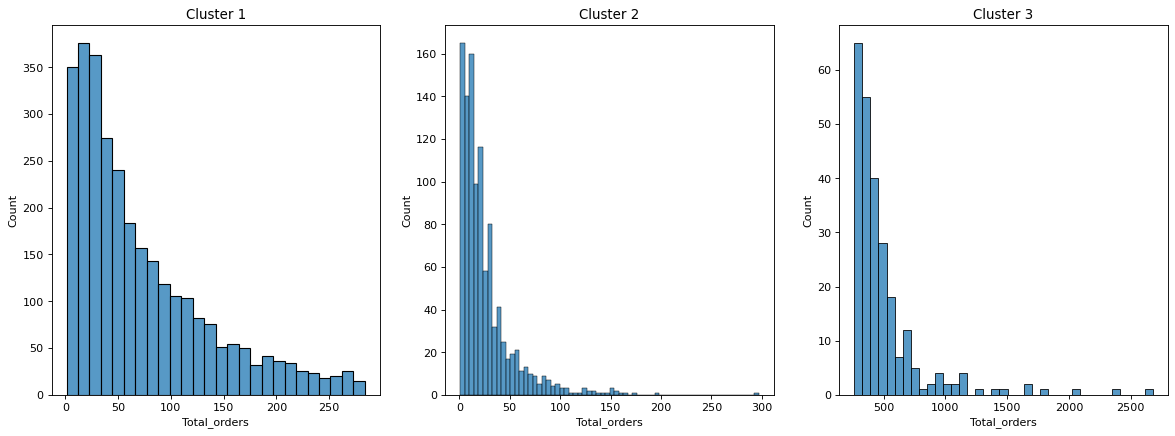

In [367]:
figure(figsize=(18, 6), dpi=80)

for i in range(3):
    
    plt.subplot(1,3,i+1)
    sns.histplot(temp[temp['Clusters'] == i]['Total_orders'])
    plt.title('Cluster {}'.format(i+1))


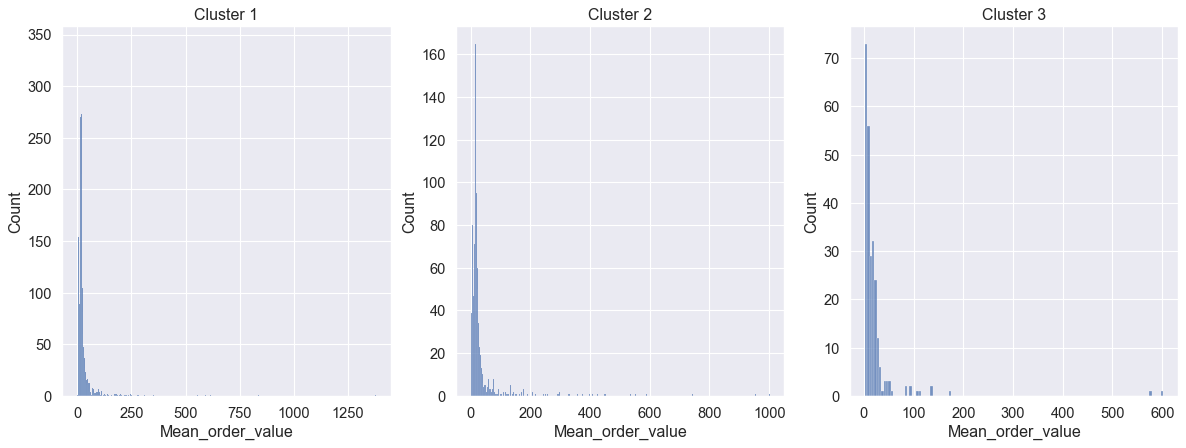

In [441]:
figure(figsize=(18, 6), dpi=80)

for i in range(3):
    
    plt.subplot(1,3,i+1)
    sns.histplot(temp[temp['Clusters'] == i]['Mean_order_value'])
    plt.title('Cluster {}'.format(i+1))


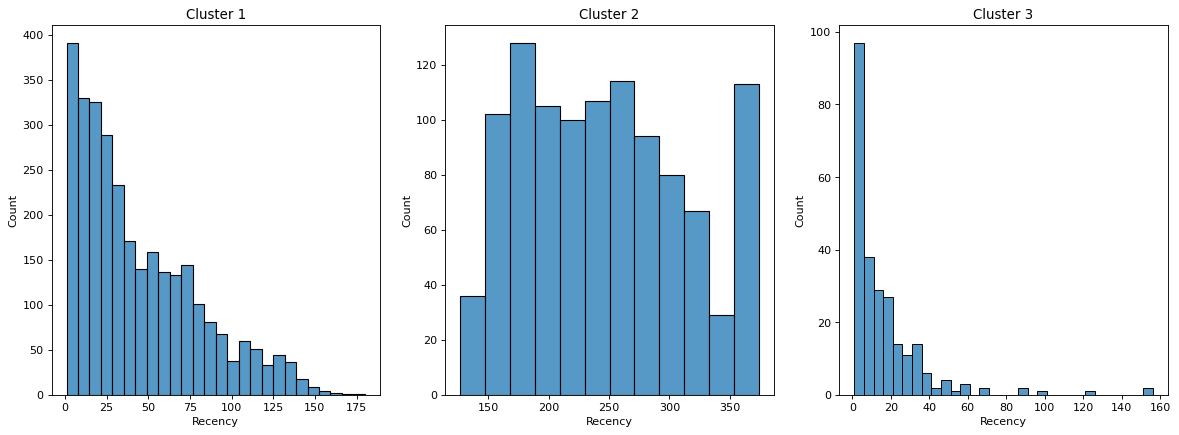

In [369]:
figure(figsize=(18, 6), dpi=80)

for i in range(3):
    
    plt.subplot(1,3,i+1)
    sns.histplot(temp[temp['Clusters'] == i]['Recency'])
    plt.title('Cluster {}'.format(i+1))


<BR>

<BR>

## Modelling

We will now train different algorithms to predict the clusters that a customer belongs to based on the data we have of them. 

#### Preparing Training and Test Datasets

In [370]:
X = df_merged
y = clusters

In [371]:
from sklearn.model_selection import train_test_split

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

<BR>


The data is such that it can also be used to classify a new customer. In that case the Total orders would be equal to 1 and the mean order value would simply be the order value of that particular order. 

### Logistic Regression

In [271]:
from sklearn.linear_model import LogisticRegression

In [373]:
logmodel = LogisticRegression()

In [374]:
logmodel.fit(X_train, y_train)

LogisticRegression()

In [375]:
predictions = logmodel.predict(X_test)

<BR>
    

In [376]:
from sklearn.metrics import accuracy_score

In [377]:
from sklearn.metrics import classification_report, confusion_matrix

<BR>

In [379]:
print("Mean Train Accuracy: {:.4f} % ".format(100*logmodel.score(X_train, y_train)))

Mean Train Accuracy: 97.2259 % 


In [380]:
print("Mean Test Accuracy: {:.4f} % ".format(100*logmodel.score(X_test, y_test)))

Mean Test Accuracy: 97.0724 % 


In [381]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.98      0.98      0.98       905
           1       0.97      0.97      0.97       321
           2       0.88      0.90      0.89        72

    accuracy                           0.97      1298
   macro avg       0.94      0.95      0.95      1298
weighted avg       0.97      0.97      0.97      1298
 

 Confusion Matrix

 [[885  11   9]
 [ 11 310   0]
 [  7   0  65]]


We will make a matrix of the actual values in each cluster for reference

In [382]:
(np.array(y_test.value_counts().sort_index())*np.eye(3)).astype(int)

array([[905,   0,   0],
       [  0, 321,   0],
       [  0,   0,  72]])

<BR>

### Support Vector Machines

In [190]:
from sklearn.model_selection import GridSearchCV

In [191]:
from sklearn.svm import LinearSVC

In [383]:
svc = LinearSVC()
gs = GridSearchCV(estimator = svc, param_grid = [{'C':np.logspace(-2,2,10)}], cv = 5)

In [384]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid=[{'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])}])

In [385]:
svc = LinearSVC(C = gs.best_params_['C'])

In [386]:
svc.fit(X_train, y_train)

LinearSVC(C=0.027825594022071243)

<BR>

In [387]:
predictions = svc.predict(X_test)

In [388]:
print("Mean Train Accuracy: {:.4f} % ".format(100*svc.score(X_train, y_train)))

Mean Train Accuracy: 96.6645 % 


In [389]:
print("Mean Test Accuracy: {:.4f} % ".format(100*svc.score(X_test, y_test)))

Mean Test Accuracy: 96.1479 % 


In [390]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.95      1.00      0.97       905
           1       0.99      0.93      0.96       321
           2       0.96      0.68      0.80        72

    accuracy                           0.96      1298
   macro avg       0.97      0.87      0.91      1298
weighted avg       0.96      0.96      0.96      1298
 

 Confusion Matrix

 [[901   2   2]
 [ 23 298   0]
 [ 23   0  49]]


In [391]:
(np.array(y_test.value_counts().sort_index())*np.eye(3)).astype(int)

array([[905,   0,   0],
       [  0, 321,   0],
       [  0,   0,  72]])

<BR>

### Decision Trees

In [200]:
from sklearn.tree import DecisionTreeClassifier

In [392]:
dtree = DecisionTreeClassifier()

In [393]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [394]:
predictions = dtree.predict(X_test)

In [395]:
print("Mean Train Accuracy: {:.4f} % ".format(100*dtree.score(X_train, y_train)))

Mean Train Accuracy: 100.0000 % 


In [396]:
print("Mean Test Accuracy: {:.4f} % ".format(100*dtree.score(X_test, y_test)))

Mean Test Accuracy: 99.1525 % 


In [397]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       905
           1       0.98      0.98      0.98       321
           2       0.99      1.00      0.99        72

    accuracy                           0.99      1298
   macro avg       0.99      0.99      0.99      1298
weighted avg       0.99      0.99      0.99      1298
 

 Confusion Matrix

 [[899   5   1]
 [  5 316   0]
 [  0   0  72]]


In [398]:
(np.array(y_test.value_counts().sort_index())*np.eye(3)).astype(int)

array([[905,   0,   0],
       [  0, 321,   0],
       [  0,   0,  72]])

<BR>

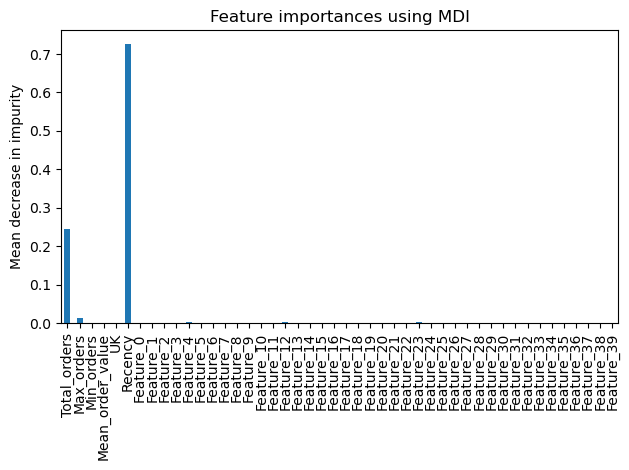

In [399]:
feature_importances = pd.Series(dtree.feature_importances_, index=X.columns)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<BR>

### Random Forest

In [208]:
from sklearn.ensemble import RandomForestClassifier

In [400]:
rfc = RandomForestClassifier()

In [401]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [402]:
predictions = rfc.predict(X_test)

In [403]:
print("Mean Train Accuracy: {:.4f} % ".format(100*rfc.score(X_train, y_train)))

Mean Train Accuracy: 100.0000 % 


In [404]:
print("Mean Test Accuracy: {:.4f} % ".format(100*rfc.score(X_test, y_test)))

Mean Test Accuracy: 99.0755 % 


In [405]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       905
           1       0.99      0.98      0.98       321
           2       1.00      0.99      0.99        72

    accuracy                           0.99      1298
   macro avg       0.99      0.99      0.99      1298
weighted avg       0.99      0.99      0.99      1298
 

 Confusion Matrix

 [[902   3   0]
 [  8 313   0]
 [  0   1  71]]


<BR>

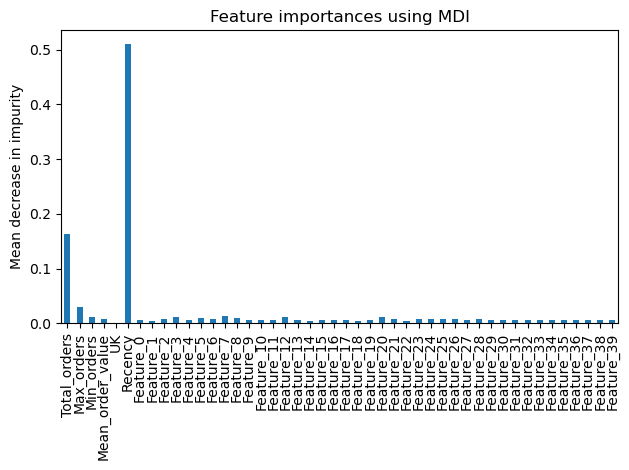

In [406]:
feature_importances = pd.Series(rfc.feature_importances_, index=X.columns)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<BR>

### Gradient Boosting Classifier

In [215]:
from sklearn.ensemble import GradientBoostingClassifier

In [407]:
gbc = GradientBoostingClassifier()

In [408]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [409]:
predictions = gbc.predict(X_test)

In [410]:
print("Mean Train Accuracy: {:.4f} % ".format(100*gbc.score(X_train, y_train)))

Mean Train Accuracy: 100.0000 % 


In [411]:
print("Mean Test Accuracy: {:.4f} % ".format(100*gbc.score(X_test, y_test)))

Mean Test Accuracy: 99.3837 % 


In [412]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       905
           1       0.99      0.98      0.99       321
           2       1.00      1.00      1.00        72

    accuracy                           0.99      1298
   macro avg       1.00      0.99      0.99      1298
weighted avg       0.99      0.99      0.99      1298
 

 Confusion Matrix

 [[902   3   0]
 [  5 316   0]
 [  0   0  72]]


<BR>

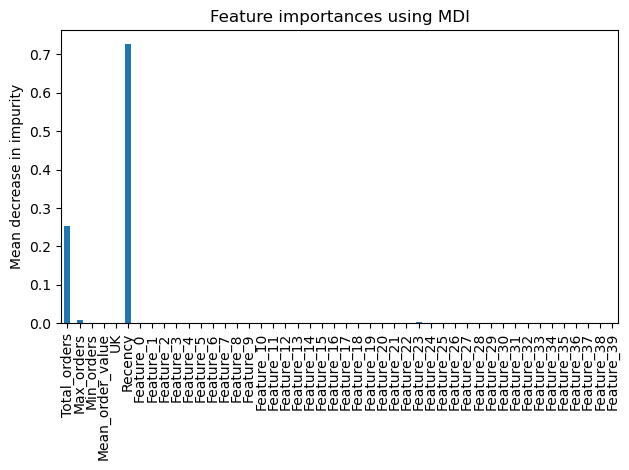

In [413]:
feature_importances = pd.Series(gbc.feature_importances_, index=X.columns)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<BR>
    

### Voting Classifier

We will now use a Voting Classifier to achieve even better accuracy .The idea behind the Voting Classifier is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

We will test both hard vote and soft vote.

We will use the three models which gave the best results individually, for our voting classifier.

In [222]:
from sklearn.ensemble import VotingClassifier

In [414]:
classifiers = ['Decision Tree', 'Random Forest', 'Gradient Boosting Classifier']

In [415]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = GradientBoostingClassifier()

First, we will test Hard Voting

In [416]:
vclf1 = VotingClassifier(estimators=[(classifiers[0], clf1), 
                                     (classifiers[1], clf2), 
                                     (classifiers[2], clf3)], voting='hard')

In [417]:
vclf1 = vclf1.fit(X_train, y_train)

In [227]:
predictions = vclf1.predict(X_test)

In [418]:
print("Mean Train Accuracy: {:.4f} % ".format(100*vclf1.score(X_train, y_train)))

Mean Train Accuracy: 100.0000 % 


In [419]:
print("Mean Test Accuracy: {:.4f} % ".format(100*vclf1.score(X_test, y_test)))

Mean Test Accuracy: 99.3837 % 


In [420]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       905
           1       0.99      0.98      0.99       321
           2       1.00      1.00      1.00        72

    accuracy                           0.99      1298
   macro avg       1.00      0.99      0.99      1298
weighted avg       0.99      0.99      0.99      1298
 

 Confusion Matrix

 [[902   3   0]
 [  5 316   0]
 [  0   0  72]]



<BR>

Now lets test soft voting

In [421]:
vclf2 = VotingClassifier(estimators=[(classifiers[0], clf1), 
                                     (classifiers[1], clf2), 
                                     (classifiers[2], clf3)], voting='soft')

In [422]:
vclf2 = vclf2.fit(X_train, y_train)

In [423]:
predictions = vclf2.predict(X_test)

In [424]:
print("Mean Train Accuracy: {:.4f} % ".format(100*vclf2.score(X_train, y_train)))

Mean Train Accuracy: 100.0000 % 


In [425]:
print("Mean Test Accuracy: {:.4f} % ".format(100*vclf2.score(X_test, y_test)))

Mean Test Accuracy: 99.3837 % 


In [426]:
print('Classification Report\n\n',classification_report(y_test, predictions),'\n\n', 'Confusion Matrix\n\n' ,confusion_matrix(y_test, predictions))

Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       905
           1       0.99      0.98      0.99       321
           2       1.00      1.00      1.00        72

    accuracy                           0.99      1298
   macro avg       1.00      0.99      0.99      1298
weighted avg       0.99      0.99      0.99      1298
 

 Confusion Matrix

 [[902   3   0]
 [  5 316   0]
 [  0   0  72]]


<BR>

In [427]:
(np.array(y_test.value_counts().sort_index())*np.eye(3)).astype(int)

array([[905,   0,   0],
       [  0, 321,   0],
       [  0,   0,  72]])

<BR>